# Training on Simulated Data
Simulation derived from [this](https://arxiv.org/abs/1908.00598).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os

# KNN
from scipy.spatial import KDTree
# Cond Gaussian
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.stats import pearsonr
# Weighted
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Gaussian Copula
from scipy import stats
from scipy.stats import norm, truncnorm

# File paths
fp_cur_dir = "./"
fp_checkpoint_dir = os.path.join(fp_cur_dir, "../", "checkpoints", "simulation")

def create_folder(fp):
    if not os.path.exists(fp):
        os.makedirs(fp)
        return True
    else:
        False

seed = 2023

create_folder(fp_checkpoint_dir)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Generate Data
- Different Noise Levels

In [2]:
def generate_data(noise_mean, noise_std, input_range = [-10, 30], ood_distance=10, num_points=20000, seed=seed):
    np.random.seed(seed)
    # Uniformly distributed x
    x = np.random.uniform(input_range[0], input_range[1], num_points)
    # y = sin + e
    y = np.sin(x)
    # e ~ N(noise_mean, noise_std)
    if noise_std > 0:
        e = np.random.normal(noise_mean, noise_std, num_points)
        noisy_y = y + e
    else:
        noisy_y = y
    df = pd.DataFrame({"x":x, "y":noisy_y})
    df = df.sort_values(by="x")
    df["ood_label"] = (df["x"] < input_range[0] + ood_distance) | (df["x"] > input_range[1] - ood_distance)
    return df

def train_valid_test_split(df,  x_col="x", y_col="y", ood_label="ood_label", seed=seed, valid_prop=0.1):
    df = df.copy()
    non_test_df, test_df = df[~df[ood_label]], df[df[ood_label]]
    non_test_df = non_test_df.sample(frac=1, random_state=seed)
    valid_size = round(valid_prop * len(non_test_df))
    train_df, valid_df = non_test_df.iloc[:-valid_size,], non_test_df.iloc[-valid_size:,]
    split_df = pd.concat([train_df, valid_df, test_df])
    split_df = split_df.reset_index(drop=True)
    split_df["split"] = (
        ["train" for i in range(len(train_df))] + ["valid" for i in range(len(valid_df))] +
        ["test" for i in range(len(test_df))]
    )
    return split_df

def plot_data(df, x_lab, y_lab, ood_label):
    df = df.copy()
    df = df.sort_values(by=x_lab)
    fig, ax = plt.subplots(1, 1, figsize=(5, 1.5), dpi=300)
    df["col"] = df[ood_label].replace({True:"orange", False:"blue"})
    ax.scatter(df[x_lab], df[y_lab], c=df["col"], s=0.1)

ood_label
False    10079
True      9921
Name: count, dtype: int64
split
test     9921
valid    5040
train    5039
Name: count, dtype: int64


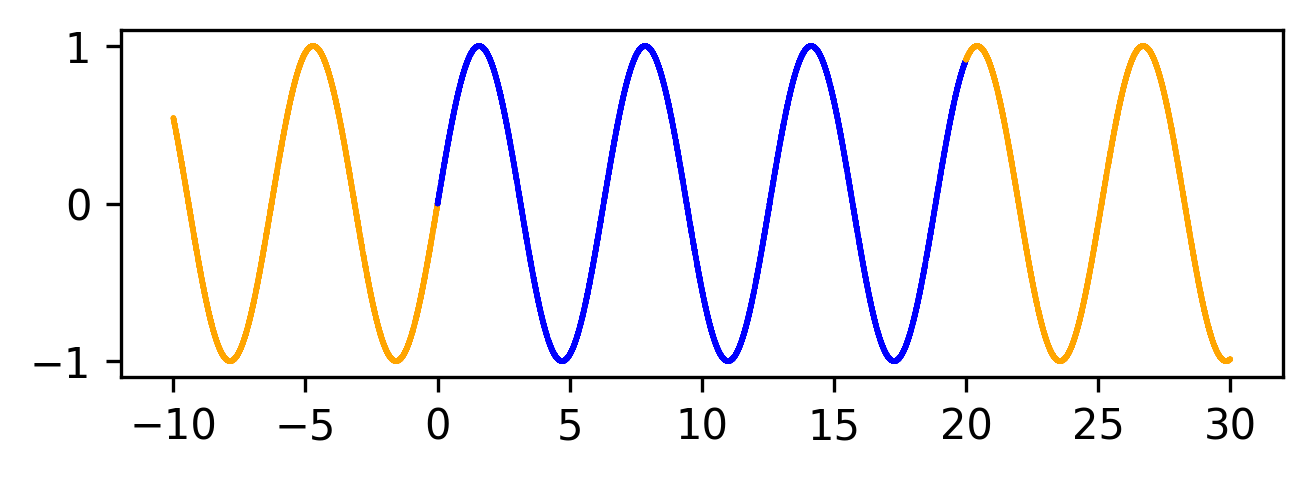

In [3]:
df_std00 = generate_data(noise_mean=0, noise_std=0)
df_std00 = train_valid_test_split(
    df_std00,  x_col="x", y_col="y", ood_label="ood_label", seed=seed, valid_prop=0.5)
print(df_std00["ood_label"].value_counts())
print(df_std00["split"].value_counts())
plot_data(df_std00, x_lab="x", y_lab="y", ood_label="ood_label")

ood_label
False    10079
True      9921
Name: count, dtype: int64
split
test     9921
valid    5040
train    5039
Name: count, dtype: int64


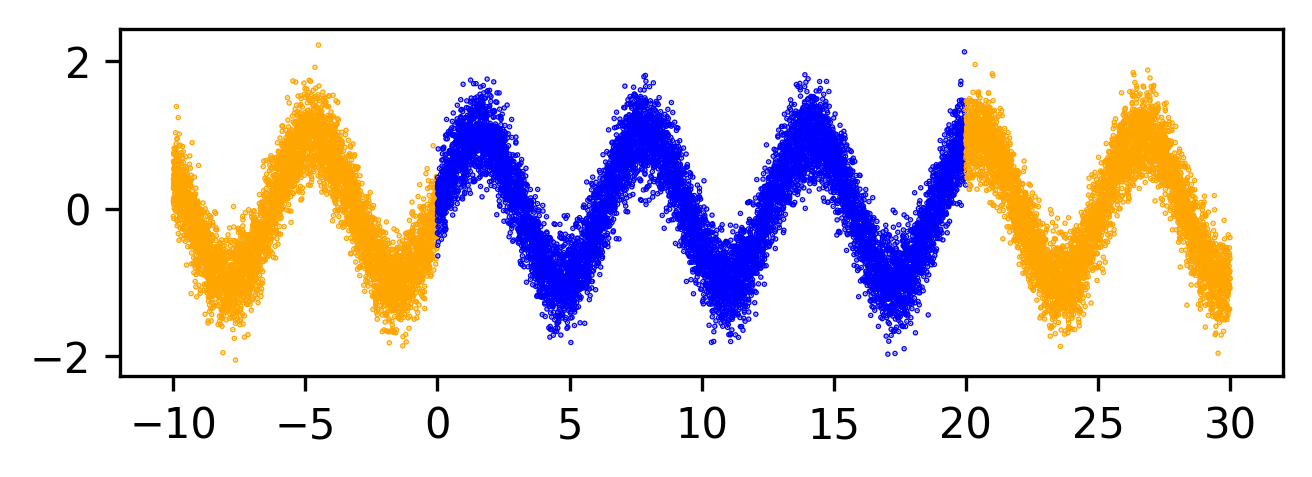

In [4]:
df_std03 = generate_data(noise_mean=0, noise_std=0.3)
df_std03 = train_valid_test_split(
    df_std03,  x_col="x", y_col="y", ood_label="ood_label", seed=seed, valid_prop=0.5)
print(df_std03["ood_label"].value_counts())
print(df_std03["split"].value_counts())
plot_data(df_std03, x_lab="x", y_lab="y", ood_label="ood_label")

ood_label
False    10079
True      9921
Name: count, dtype: int64
split
test     9921
valid    5040
train    5039
Name: count, dtype: int64


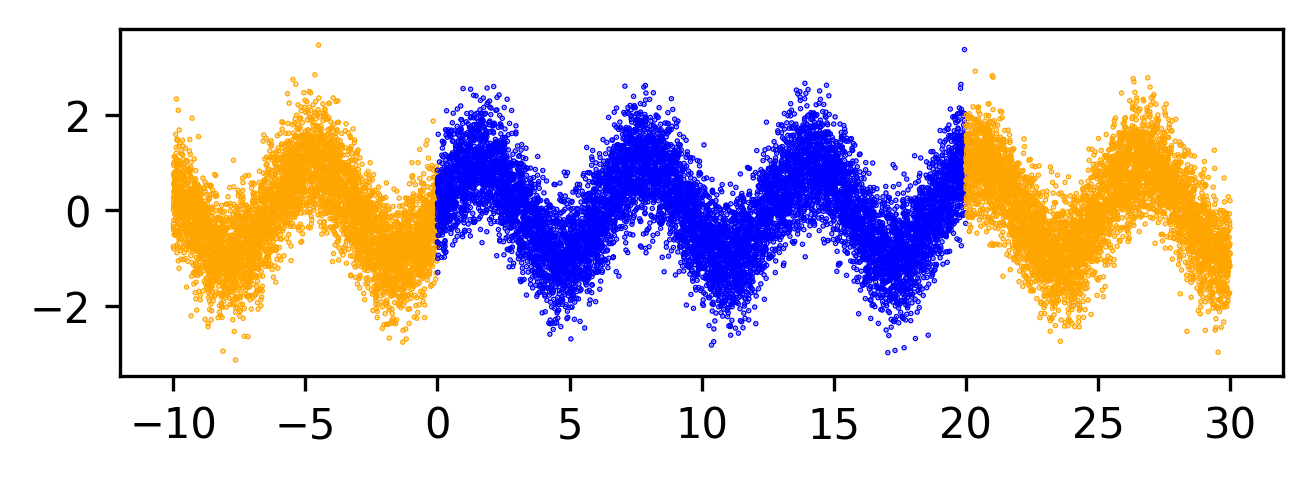

In [5]:
df_std06 = generate_data(noise_mean=0, noise_std=0.6)
df_std06 = train_valid_test_split(
    df_std06,  x_col="x", y_col="y", ood_label="ood_label", seed=seed, valid_prop=0.5)
print(df_std06["ood_label"].value_counts())
print(df_std06["split"].value_counts())
plot_data(df_std06, x_lab="x", y_lab="y", ood_label="ood_label")

## Define Autoencoder Model
Create simple model to predict y given x

In [6]:
def set_seed(seed):
    import os
    import random
    tf.config.experimental.enable_op_determinism()
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def display_history(history, show_acc=False):
    if show_acc:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 2.5))
        axes[0].plot(history.history['loss'])
        axes[0].plot(history.history['val_loss'])
        axes[0].set_title('Model Loss')
        axes[0].set_ylabel('Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].legend(['Train', 'Val'], loc='upper left')
        axes[1].plot(history.history['accuracy'])
        axes[1].plot(history.history['val_accuracy'])
        axes[1].set_title('Model Accuracy')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['Train', 'Val'], loc='upper left')
        axes[2].plot(history.history['f1_score'])
        axes[2].plot(history.history['val_f1_score'])
        axes[2].set_title('Model F1 Score')
        axes[2].set_ylabel('F1 Score')
        axes[2].set_xlabel('Epoch')
        axes[2].legend(['Train', 'Val'], loc='upper left')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 2.5))
        axes.plot(history.history['loss'])
        axes.plot(history.history['val_loss'])
        axes.set_title('Model Loss')
        axes.set_ylabel('Loss')
        axes.set_xlabel('Epoch')
        axes.legend(['Train', 'Val'], loc='upper left')
    plt.tight_layout()
    plt.show()

class AE_Regressor:
    def __init__(self, width, predictors, output_features):
        from keras.layers import Dense, Dropout
        self.predictors = predictors
        self.output_features = output_features
        self.num_predictors = len(self.predictors)
        self.num_outputs = len(self.output_features)
        self.width = width
        
        # Instantiate model layers
        self.inputs = tf.keras.Input(shape=(self.num_predictors,))
        self.normalisation = tf.keras.layers.Normalization(name="normalisation")
        self.encoder = tf.keras.Sequential([
            Dense(self.width, activation="relu"),
#             Dropout(rate=0.1),
            Dense(self.width, activation="relu"),
            Dense(self.width, activation="relu"),
        ], name="encoder")
        self.decoder = tf.keras.Sequential([
            Dense(self.width, activation="relu"),
            Dense(self.width, activation="relu"),
            Dense(self.num_predictors),
        ], name="decoder")
        self.regressor = Dense(self.num_outputs, name="regressor")      

    # Smote is external
    def train_regressor(
        self, train_X, train_y, val_X, val_y, batch_size, max_epochs, verbose, patience):
        from tensorflow.keras.callbacks import EarlyStopping
        # Fit the standard scaler 
        self.normalisation.adapt(train_X)
        
        # Define regressor
        pred = self.normalisation(self.inputs)
        pred = self.encoder(pred)
        pred = self.regressor(pred)
        self.predictor = tf.keras.Model(inputs=self.inputs, outputs=pred, name="regression_model")
        # Train classifier
        self.predictor.compile(
            loss="mse",
            optimizer=tf.keras.optimizers.Adam()
        )
        es = EarlyStopping(
            monitor='val_loss', mode='min', verbose=1, patience=patience, restore_best_weights=True)
        self.predictor_history = self.predictor.fit(
            train_X, train_y, 
            epochs=max_epochs, 
            validation_data=(val_X, val_y),
            verbose=verbose,
            batch_size=batch_size,
            callbacks=[es],
        )
        print("- Regressor Training History")
        display_history(self.predictor_history)
        best_index = np.argmin(self.predictor_history.history['val_loss'])
        return (
            self.predictor_history.history['val_loss'][best_index], 
            best_index
        )
        
    def train_decoder(
        self, train_X, val_X, batch_size, max_epochs, verbose, patience):
        from tensorflow.keras.callbacks import EarlyStopping
        # Define AE
        self.encoder.trainable=False # Freeze weights
        
        x = self.normalisation(self.inputs)
        x = self.encoder(x)
        x = self.decoder(x)
        self.ae = tf.keras.Model(inputs=self.inputs, outputs=x, name="ae_model")
        # Train AE
        self.ae.compile(
            loss="mse",
            optimizer=tf.keras.optimizers.Adam()
        )
        es = EarlyStopping(
            monitor='val_loss', mode='min', verbose=1, patience=patience,restore_best_weights=True)
        self.ae_history = self.ae.fit(
            train_X, train_X, 
            epochs=max_epochs, 
            validation_data=(val_X, val_X),
            verbose=verbose,
            batch_size=batch_size,
            callbacks=[es]
        )
        print("- Autoencoder Training History")
        display_history(self.ae_history)
        return min(self.ae_history.history['val_loss'])

    def predict(self, inputs):
        # Normalise
        norm_output = self.normalisation(inputs)
        # Encode
        encoder_output = self.encoder(norm_output)
        # Reconstruct
        decoder_output = self.decoder(encoder_output)
        # Get forecast result
        regressor_output = self.regressor(encoder_output)
        
        return regressor_output, decoder_output
    
        
def save_model(model, name, fp_checkpoints, override=False):
    import pickle
    model_folder = os.path.join(fp_checkpoints, name)
    if os.path.exists(model_folder):
        print("Model checkpoint already exists!")
        if not override:
            return
    else:
        os.makedirs(model_folder)
    
    # Save Parameters
    parameters_to_save = dict(
        predictors = model.predictors,
        output_features = model.output_features,
        width = model.width
    )   
    parameter_filename = os.path.join(fp_checkpoints, name, "parameters.pickle")
    with open(parameter_filename, 'wb') as handle:
        pickle.dump(parameters_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Save Model
    inputs = model.inputs
    normalisation_output = model.normalisation(inputs)
    encoder_output = model.encoder(normalisation_output)
    decoder_output = model.decoder(encoder_output)
    regressor_output = model.regressor(encoder_output)
    model = tf.keras.Model(inputs, [regressor_output, decoder_output])
    model_filename = os.path.join(fp_checkpoints, name, "model.h5")
    model.save(model_filename)
    print("Model saved!")

def load_model(name, fp_checkpoints): 
    import pickle
    model_folder = os.path.join(fp_checkpoints, name)
    parameter_filename = os.path.join(fp_checkpoints, name, "parameters.pickle")
    model_filename = os.path.join(fp_checkpoints, name, "model.h5")
    
    if not os.path.exists(model_folder):
        print("model checkpoint does not exist!")
        return
    model = tf.keras.models.load_model(model_filename)
    with open(parameter_filename, 'rb') as handle:
        parameters = pickle.load(handle)
    
    ae_regressor = AE_Regressor(
        parameters["width"], parameters["predictors"], parameters["output_features"])
    ae_regressor.normalisation = model.get_layer("normalisation")
    ae_regressor.encoder = model.get_layer("encoder")
    ae_regressor.decoder = model.get_layer("decoder")
    ae_regressor.regressor = model.get_layer("regressor")
    
    return ae_regressor

def model_training_ae(
    width, predictors, pred_cols, train_df, valid_df, seed,
    batch_size=128, max_epochs=5000, verbose=1, patience=10):
    
    from tqdm import tqdm
    import time
    set_seed(seed)
    
    # Get data
    train_X, train_y = (
        train_df[predictors].values.astype('float32'), train_df[pred_cols].values.astype('float32'))
    valid_X, valid_y = (
        valid_df[predictors].values.astype('float32'), valid_df[pred_cols].values.astype('float32'))
    
    # Train Regressor
    ae_regressor = AE_Regressor(width, predictors, pred_cols)
    
    start = time.time()
    
    # Train Regressor
    valid_loss_regressor, best_epoch = ae_regressor.train_regressor(
        train_X=train_X, train_y=train_y, val_X=valid_X, val_y=valid_y, 
        batch_size=batch_size, max_epochs=max_epochs, verbose=verbose, patience=patience)
    
    # Train decoder
    valid_loss_ae = ae_regressor.train_decoder(
        train_X=train_X, val_X=valid_X, batch_size=batch_size, max_epochs=max_epochs, verbose=verbose, patience=patience)
    
    print(f"Training took {time.time()-start}s.")
    return ae_regressor


## Prediction Functions

In [12]:
def model_prediction_ae(ae_regressor, all_df, predictors, pred_cols, seed=seed):
    all_df = all_df.copy()
    
    # Prediction
    x = all_df[predictors].values.astype('float32')
    y = all_df[pred_cols].values.astype('float32')
    y_pred, x_reconstruction = ae_regressor.predict(inputs=x)

    # All columns
    predicted_colnames = [col+"_pred" for col in pred_cols]
    reconstruction_colnames = [col+"_reconstruction" for col in predictors]
    rue_colname = "rue"
    all_df[predicted_colnames] = y_pred
    all_df[reconstruction_colnames] = x_reconstruction
    all_df[rue_colname] = np.mean(np.abs(x_reconstruction-x), axis=1)
    
    return all_df

def generate_pi(df, predictors, pred_cols, split_col, pi_function, alpha=0.05, seed=seed):
    df = df.copy()
    # Get pi
    df_val = df.loc[df[split_col]=="valid", :]
    df = pi_function(df_val, df, predictors, pred_cols, alpha=alpha, seed=seed)

    # Get ood
    ue_col = "rue"
    df["ood"] = df[ue_col] > df_val["rue"].max()
    return df 

### KNN PI

In [16]:
def knn_prediction_interval(df_val, df_test, predictors, pred_cols, alpha=0.05, seed=seed):
    pi_label = "_pi"
    df_val, df_test = df_val.copy(), df_test.copy()

    # Set K = sqrt of size of validation set
    k = round(np.sqrt(len(df_val)))

    # Get reconstruction errors
    reconstruction_cols = [col+"_reconstruction" for col in predictors]
    valid_re = np.abs(df_val[predictors].values - df_val[reconstruction_cols].values)
    test_re = np.abs(df_test[predictors].values - df_test[reconstruction_cols].values)

    # Find neighbours
    n_val = len(valid_re)
    kdtree = KDTree(valid_re)
    dist, ind = kdtree.query(test_re, k=k, workers=-1)

    for col in pred_cols:
        # 1. Val df
        # Get error for each variable
        val_y = df_val[col].values.astype('float32')
        val_y_pred = df_val[col+"_pred"].values.astype('float32')
        val_pe = np.abs(val_y-val_y_pred)

        # Nearbouring prediction errors
        neighbour_pe = val_pe[ind]

        # PI = 0.95 Percentile of neigbouring errors
        df_test[col+pi_label] = np.quantile(neighbour_pe, np.ceil((k+1)*(1-alpha))/k, method='higher')
    
    return df_test

### Weighted

In [60]:
def weighted_percentile_matrix(values, weights, percentile):
    ix = np.argsort(values, axis=-1) # sort within each 
    values = np.take_along_axis(values, ix, axis=-1) # sort data
    weights = np.take_along_axis(weights, ix, axis=-1) # sort weights
    cdf = (np.cumsum(weights, axis=-1) - 0.5 * weights) / np.sum(weights, axis=-1, keepdims=True) # 'like' a CDF function
    return [np.interp(percentile, cdf[i], values[i]) for i in range(values.shape[0])]

def weighted_prediction_interval(df_val, df_test, predictors, pred_cols, alpha=0.05, seed=seed):
    pi_label = "_pi"
    df_val, df_test = df_val.copy(), df_test.copy()

    # Get reconstruction errors
    reconstruction_cols = [col+"_reconstruction" for col in predictors]
    valid_re = np.abs(df_val[predictors].values - df_val[reconstruction_cols].values)
    test_re = np.abs(df_test[predictors].values - df_test[reconstruction_cols].values)

    # Set K = sqrt of size of validation set
    n_val = len(df_val)
    n_test = len(df_test)
    n_feat = len(predictors)
    k = round(np.sqrt(n_val))

    # Mahalanobis distance = euclidan distance after pc with whitening
    # - https://stackoverflow.com/questions/69811792/mahalanobis-distance-not-equal-to-euclidean-distance-after-pca
    re_scaler = StandardScaler()
    pca = PCA(whiten=True)
    valid_re = re_scaler.fit_transform(valid_re)
    valid_re = pca.fit_transform(valid_re)
    test_re = re_scaler.transform(test_re)
    test_re = pca.transform(test_re)

    # Find neighbours
    sigma = 25
    kdtree = KDTree(valid_re)
    mahalanobis_dist, ind = kdtree.query(test_re, k=k, workers=-1, p=2)
    dist = mahalanobis_dist/np.sqrt(n_feat) # already sorted by distance (nearest first; ascending order of distance)
    weights = np.exp(-np.square(dist)/(2*sigma**2)) # descending order of weights
    print(np.sum(np.sum(weights, axis=1)==0))
    print(np.mean(np.var(weights, axis=1)))
    modified_alpha = np.ceil((k+1)*(1-alpha))/k

    for col in tqdm(pred_cols):
        # 1. Val df
        # Get error for each variable
        val_y = df_val[col].values.astype('float32')
        val_y_pred = df_val[col+"_pred"].values.astype('float32')
        val_pe = np.abs(val_y-val_y_pred)

        # Nearbouring prediction errors
        neighbour_pe = val_pe[ind]

        # # PI = 0.95 Weighted Percentile of neigbouring errors
        # pis = []
        # for i in tqdm(range(n_test), total=n_test, leave=False):
        #     df = pd.DataFrame({'v': neighbour_pe[i], 'w': weights[i]})
        #     # display(df)
        #     calc = wc.Calculator('w')  # w designates weight
        #     pi = calc.quantile(df, 'v', modified_alpha)
        #     pis.append(pi)
        pis = weighted_percentile_matrix(values=neighbour_pe, weights=weights, percentile=modified_alpha)
        df_test[col+pi_label] = pis
    
    return df_test

### Conditional Gaussian

In [24]:
class ConditionalGaussianDistribution:
    def __init__(self, Y, X):
        self.Y = Y # Assume shape = (num_samples, num_output)
        self.X = X # Assume shape = (num_samples, num_inputs)
        self.YX = np.concatenate((Y, X), axis=-1) # Assume shape = (num_samples, num_output+num_inputs)
        self.num_Y = self.Y.shape[1]
        self.num_X = self.X.shape[1]

        # Fitting
        self.esti_mean_YX = np.mean(self.YX, axis = 0) # (num_output+num_inputs,)
        self.esti_covariance_matrix_YX = np.cov(self.YX.T, ddof=1) # (num_output+num_inputs, num_output+num_inputs)
        
        # Useful stats
        self.mu_Y = self.esti_mean_YX[:self.num_Y]
        self.mu_X = self.esti_mean_YX[self.num_Y:]
        self.cov_XX = self.esti_covariance_matrix_YX[self.num_Y:, self.num_Y:]
        self.cov_YY = self.esti_covariance_matrix_YX[:self.num_Y, :self.num_Y]
        self.cov_YX = self.esti_covariance_matrix_YX[:self.num_Y, self.num_Y:]
        self.cov_XY = self.esti_covariance_matrix_YX[self.num_Y:, :self.num_Y]
        
    def get_conditional_mean(self, alpha):
        # alpha = (num_samples, self.num_X)
        return (
            self.mu_Y + 
            np.linalg.multi_dot((
                self.cov_YX,
                np.linalg.inv(self.cov_XX),
                (alpha - self.mu_X).T))
        ).flatten()
        
    def get_conditional_cov(self):
        return (
            self.cov_YY - 
            np.linalg.multi_dot((
                self.cov_YX,
                np.linalg.inv(self.cov_XX), 
                self.cov_XY))
        ).flatten()[0]

def cond_gauss_prediction_interval(df_val, df_test, predictors, pred_cols, alpha=0.05, seed=seed):
    pi_label = "_pi"
    df_val, df_test = df_val.copy(), df_test.copy()

    # Get reconstruction errors
    reconstruction_cols = [col+"_reconstruction" for col in predictors]
    valid_re = np.abs(df_val[predictors].values - df_val[reconstruction_cols].values)
    test_re = np.abs(df_test[predictors].values - df_test[reconstruction_cols].values)

    n_val = len(df_val)

    for col in tqdm(pred_cols):
        # 1. Val df
        # Get error for each variable
        val_y = df_val[col].values.astype('float32')
        val_y_pred = df_val[col+"_pred"].values.astype('float32')
        val_pe = np.abs(val_y-val_y_pred)

        # Stack both pe and reconstruction error to fit the cond gaussian model
        val_data = np.hstack((np.expand_dims(val_pe, axis=1), valid_re))
        
        # Parameter Estimation on Validation Set
        uncertainty_distribution = ConditionalGaussianDistribution(
            Y=np.expand_dims(val_pe, axis=1), 
            X= valid_re
        )
        esti_conditional_mean_Y = uncertainty_distribution.get_conditional_mean(test_re)
        esti_conditional_std_Y = np.sqrt(uncertainty_distribution.get_conditional_cov())
        
        # 1-alpha/2 -> Because Gaussian is symmetrical
        df_test[col+pi_label] = norm.ppf(1-alpha, loc=esti_conditional_mean_Y, scale=esti_conditional_std_Y).flatten()
    
    return df_test


### Gaussian Copula

In [34]:
EPSILON = np.finfo(np.float32).eps

class ConditionalGaussianDistribution:
    def __init__(self, Y, X):
        self.Y = Y # Assume shape = (num_samples, num_output)
        self.X = X # Assume shape = (num_samples, num_inputs)
        self.YX = np.concatenate((Y, X), axis=-1) # Assume shape = (num_samples, num_output+num_inputs)
        self.num_Y = self.Y.shape[1]
        self.num_X = self.X.shape[1]

        # Fitting
        self.esti_mean_YX = np.mean(self.YX, axis = 0) # (num_output+num_inputs,)
        self.esti_covariance_matrix_YX = np.cov(self.YX.T, ddof=1) # (num_output+num_inputs, num_output+num_inputs)
        
        # Useful stats
        self.mu_Y = self.esti_mean_YX[:self.num_Y]
        self.mu_X = self.esti_mean_YX[self.num_Y:]
        self.cov_XX = self.esti_covariance_matrix_YX[self.num_Y:, self.num_Y:]
        self.cov_YY = self.esti_covariance_matrix_YX[:self.num_Y, :self.num_Y]
        self.cov_YX = self.esti_covariance_matrix_YX[:self.num_Y, self.num_Y:]
        self.cov_XY = self.esti_covariance_matrix_YX[self.num_Y:, :self.num_Y]
        
    def get_conditional_mean(self, alpha):
        # alpha = (num_samples, self.num_X)
        return (
            self.mu_Y + 
            np.linalg.multi_dot((
                self.cov_YX,
                np.linalg.inv(self.cov_XX),
                (alpha - self.mu_X).T))
        ).flatten()
        
    def get_conditional_cov(self):
        return (
            self.cov_YY - 
            np.linalg.multi_dot((
                self.cov_YX,
                np.linalg.inv(self.cov_XX), 
                self.cov_XY))
        ).flatten()[0]

class GaussianCopula:
    def __init__(self, X):
        self.X = X
        self.n_feat = X.shape[1]

        # Get all CDFs
        self.cdfs = []
        for i_feat in range(self.n_feat):
            self.cdfs.append(stats.ecdf(X[:, i_feat]))

    def add_y(self, y):
        self.y = y
        self.y_cdf = stats.ecdf(self.y)
        
    def X_to_V(self, cur_X):
        X_Vi = np.empty(cur_X.shape)
        for i_feat in range(self.n_feat):
            Fi = self.cdfs[i_feat].cdf.evaluate(cur_X[:, i_feat]).clip(EPSILON, 1 - EPSILON)
            X_Vi[:,i_feat] = norm.ppf(Fi)
        return X_Vi

    def Y_to_V(self, cur_y):
        y_Fi = self.y_cdf.cdf.evaluate(cur_y).clip(EPSILON, 1 - EPSILON)
        y_Vi = norm.ppf(y_Fi)
        return y_Vi

    def V_to_Y(self, cur_y_Vi):
        y_Fi = norm.cdf(cur_y_Vi)
        y = np.percentile(self.y, y_Fi*100, axis=0, method="higher")
        return y

def gauss_copula_prediction_interval(df_val, df_test, predictors, pred_cols, alpha=0.05, seed=seed):
    pi_label = "_pi"
    df_val, df_test = df_val.copy(), df_test.copy()

    # Get reconstruction errors
    reconstruction_cols = [col+"_reconstruction" for col in predictors]
    valid_re = np.abs(df_val[predictors].values - df_val[reconstruction_cols].values)
    test_re = np.abs(df_test[predictors].values - df_test[reconstruction_cols].values)
    
    # Convert reconstruction and prediction error to V
    gc = GaussianCopula(valid_re)
    valid_re = gc.X_to_V(valid_re)
    test_re = gc.X_to_V(test_re)

    n_val = len(df_val)

    for col in tqdm(pred_cols):
        # 1. Val df
        # Get error for each variable
        val_y = df_val[col].values.astype('float32')
        val_y_pred = df_val[col+"_pred"].values.astype('float32')
        val_pe = np.abs(val_y-val_y_pred)

        gc.add_y(val_pe)
        val_pe = gc.Y_to_V(val_pe)

        # Parameter Estimation on Validation Set
        uncertainty_distribution = ConditionalGaussianDistribution(
            Y=np.expand_dims(val_pe, axis=1), 
            X= valid_re
        )
        esti_conditional_mean_Y = uncertainty_distribution.get_conditional_mean(test_re)
        esti_conditional_std_Y = np.sqrt(uncertainty_distribution.get_conditional_cov())

        pi_V = norm.ppf(1-alpha, loc=esti_conditional_mean_Y, scale=esti_conditional_std_Y).flatten()
        # print(pi_V)

        # Convert from V space back to Y
        df_test[col+pi_label] = gc.V_to_Y(pi_V)
    
    return df_test


## Evaluation Functions

In [92]:
def save_image_to_file(name):
    from datetime import datetime
    if not os.path.exists("images"):
        os.makedirs("images")
    fp_image_folder = os.path.join(fp_checkpoint_dir, "images")
    create_folder(fp_image_folder)
    # {datetime.now().strftime("%H_%M_%S")}
    fp_image = os.path.join(fp_image_folder, f'{name}.jpg')
    plt.savefig(fp_image, bbox_inches="tight")

def plot_predictions(
    df, x_lab, y_lab, title, pred_lab, ci_lab, ue_lab, ylabel, ood_lab=None, save_images=False, with_ci=True, 
    xmin=-10, xmax=30, only_pi=True, image_name=None):
    df = df.copy()
    df = df.sort_values(by=x_lab)
    
    if only_pi:
        fig, ax = plt.subplots(1, 1, figsize=(4, 0.6), dpi=300, sharex=True)
        df["col"] = df[ood_lab].replace({True:"orange", False:"blue"})
        ax.scatter(df[x_lab], df[y_lab], c=df["col"], s=0.1)
        df["color"] = df[ood_lab].replace({True:"red", False:"green"})
        ax.plot(df[x_lab], df[pred_lab], color="green")
        if with_ci:
            # print(df[ci_lab])
            if ood_lab:
                ax.fill_between(
                    df[x_lab[0]], 
                    (df[pred_lab]-df[ci_lab]), (df[pred_lab]+df[ci_lab]), 
                    where=df[ood_lab], facecolor='red', interpolate=True,
                    alpha=0.5
                )     
                ax.fill_between(
                    df[x_lab[0]], 
                    (df[pred_lab]-df[ci_lab]), (df[pred_lab]+df[ci_lab]), 
                    where=df[ood_lab]==False, facecolor='green', interpolate=True,
                    alpha=0.5
                )     
            else:
                ax.fill_between(
                    df[x_lab[0]], 
                    (df[pred_lab]-df[ci_lab]), (df[pred_lab]+df[ci_lab]), 
                    color='green', alpha=0.5
                )
        ax.set_ylabel(y_lab[0])
        ax.set_xlabel(x_lab[0])
        ax.set_title(title)
        if save_images:
            save_image_to_file("plot_predictions" if image_name is None else image_name)
        plt.show()
        
    else:
        fig, axes = plt.subplots(3, 1, figsize=(4, 2), dpi=300, sharex=True)
        df["col"] = df[ood_lab].replace({True:"orange", False:"blue"})
        axes[0].scatter(df[x_lab], df[y_lab], c=df["col"], s=0.1)
        df["color"] = df[ood_lab].replace({True:"red", False:"green"})
        axes[0].plot(df[x_lab], df[pred_lab], color="green")
        if with_ci:
            print(df[ci_lab])
            if ood_lab:
                axes[0].fill_between(
                    df[x_lab[0]], 
                    (df[pred_lab]-df[ci_lab]), (df[pred_lab]+df[ci_lab]), 
                    where=df[ood_lab], facecolor='red', interpolate=True,
                    alpha=0.5
                )     
                axes[0].fill_between(
                    df[x_lab[0]], 
                    (df[pred_lab]-df[ci_lab]), (df[pred_lab]+df[ci_lab]), 
                    where=df[ood_lab]==False, facecolor='green', interpolate=True,
                    alpha=0.5
                )     
            else:
                axes[0].fill_between(
                    df[x_lab[0]], 
                    (df[pred_lab]-df[ci_lab]), (df[pred_lab]+df[ci_lab]), 
                    color='green', alpha=0.5
                )
        axes[0].set_title(title)
        axes[0].set_ylabel(y_lab[0])
        axes[1].set_ylabel("|y-$\hat{y}$|")
        axes[1].plot(df[x_lab], np.abs(df[y_lab]-df[pred_lab]), color="red")
        
        axes[2].plot(df[x_lab], np.abs(df[ue_lab]), color="red")
        axes[2].set_ylabel(ylabel)
        axes[2].set_xlabel(x_lab[0])
        axes[2].set_yticks(np.arange(round(min(np.abs(df[ue_lab]))), round(max(np.abs(df[ue_lab]))), 5))
        # plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)
        if save_images:
            save_image_to_file("plot_predictions" if image_name is None else image_name)
        plt.show()

def calculate_coverage(pi_df, y_col, y_pred_col, pi_col, split_col):
    coverage_df = []
    for split, split_df in pi_df.groupby(split_col):
        coverage_df.append({
            "Split": split,
            "Coverage": round(np.mean(np.abs(split_df[y_col] - split_df[y_pred_col]) <= split_df[pi_col]), 3)*100
        })
    return pd.DataFrame(coverage_df)

## Train Autoencoder Model

In [90]:
def train_all_ae_models(
    df_dict, checkpoint_name, split_col, x_col="x", y_col="y", seed=seed, fp_checkpoint_dir=fp_checkpoint_dir):
    model_dict, pred_df_dict = {}, {}
    fp_all_model_folder = os.path.join(fp_checkpoint_dir, checkpoint_name)
    if not os.path.exists(fp_all_model_folder):
        os.makedirs(fp_all_model_folder)
    for df_label, df in tqdm(df_dict.items(), total=len(df_dict)):
        print(f"{df_label}:")
        fp_cur_model_folder = os.path.join(fp_all_model_folder, df_label)
        fp_cur_model_pred_df = os.path.join(fp_cur_model_folder, f"{df_label}.csv")
        if not os.path.exists(fp_cur_model_folder):
            os.makedirs(fp_cur_model_folder)
        
            (train_df, valid_df) = (
                df[df[split_col]=="train"], df[df[split_col]=="valid"]
            )
            ae_regressor = model_training_ae(
                width=100, predictors=[x_col], pred_cols=[y_col], train_df=train_df, valid_df=valid_df, seed=seed,
                batch_size=512, max_epochs=5000, verbose=1, patience=10)
            save_model(
                model=ae_regressor, name=df_label, fp_checkpoints=fp_cur_model_folder, override=False)
            model_dict[df_label] = ae_regressor
            pred_df = model_prediction_ae(ae_regressor=ae_regressor, all_df=df, predictors=[x_col], pred_cols=[y_col], seed=seed)
            pred_df_dict[df_label] = pred_df
            pred_df.to_csv(fp_cur_model_pred_df, index=False)
        
        else:
            print("Model Exists!")
            continue
    return model_dict, pred_df_dict

def predict_w_all_ae_models(df_dict, model_dict, checkpoint_name, split_col, x_col="x", y_col="y", seed=seed, fp_checkpoint_dir=fp_checkpoint_dir):
    pred_df_dict = {}
    fp_all_model_folder = os.path.join(fp_checkpoint_dir, checkpoint_name)
    for df_label, ae_regressor in tqdm(model_dict.items(), total=len(model_dict)):
        df = df_dict[df_label]
        fp_cur_model_folder = os.path.join(fp_all_model_folder, df_label)
        fp_cur_model_pred_df = os.path.join(fp_cur_model_folder, f"{df_label}.csv")
        pred_df = model_prediction_ae(ae_regressor=ae_regressor, all_df=df, predictors=[x_col], pred_cols=[y_col], seed=seed)
        pred_df_dict[df_label] = pred_df
        pred_df.to_csv(fp_cur_model_pred_df, index=False)
    return pred_df_dict

def load_all_ae_models(checkpoint_name, fp_checkpoint_dir=fp_checkpoint_dir):
    model_dict, pred_df_dict = {}, {}
    fp_all_model_folder = os.path.join(fp_checkpoint_dir, checkpoint_name)
    if not os.path.exists(fp_all_model_folder):
        print("Model folder does not exist!")
        return
    model_folders = os.listdir(fp_all_model_folder)
    model_folders.sort()
    for df_label in model_folders:
        fp_cur_model_folder = os.path.join(fp_all_model_folder, df_label)
        fp_cur_model_pred_df = os.path.join(fp_cur_model_folder, f"{df_label}.csv")
        ae_regressor = load_model(name=df_label, fp_checkpoints=fp_cur_model_folder)
        pred_df = pd.read_csv(fp_cur_model_pred_df)
        model_dict[df_label] = ae_regressor
        pred_df_dict[df_label] = pred_df
    return model_dict, pred_df_dict

def evaluate_all_ae_models(
    pred_df_dict, pi_name, pi_function, save_images=False, with_ci=True, x_col="x", y_col="y", split_col="split", ood_col="ood", only_pi=False):
    for df_label, df in pred_df_dict.items():
        print(f"{df_label}:")
        pi_df = generate_pi(df, predictors=[x_col], pred_cols=[y_col], split_col=split_col, pi_function=pi_function)
        plot_predictions(
            pi_df, x_lab=x_col, y_lab=y_col, title=pi_name,
            pred_lab=y_col+"_pred", ci_lab=y_col+"_pi", ue_lab="rue", ylabel="RUE",
            ood_lab=ood_col, save_images=save_images, with_ci=with_ci, only_pi=only_pi, image_name=f"{pi_name}_{df_label}")
        display(calculate_coverage(pi_df, y_col, y_pred_col=y_col+"_pred", pi_col=y_col+"_pi", split_col=split_col))

In [125]:
ae_model_dict, ae_pred_df_dict = train_all_ae_models(
    df_dict={"std00":df_std00, "std03":df_std03, "std06":df_std06}, split_col="split", checkpoint_name="ae_models"
)

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1500.11it/s]

std00:
Model Exists!
std03:
Model Exists!
std06:
Model Exists!


In [10]:
ae_model_dict, ae_pred_df_dict = load_all_ae_models(checkpoint_name="ae_models")

In [28]:
ae_pred_df_dict = predict_w_all_ae_models(df_dict={"std00":df_std00, "std03":df_std03, "std06":df_std06}, model_dict=ae_model_dict, split_col="split", checkpoint_name="ae_models")

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


## Evaluate AE Models

### KNN PI

std00:


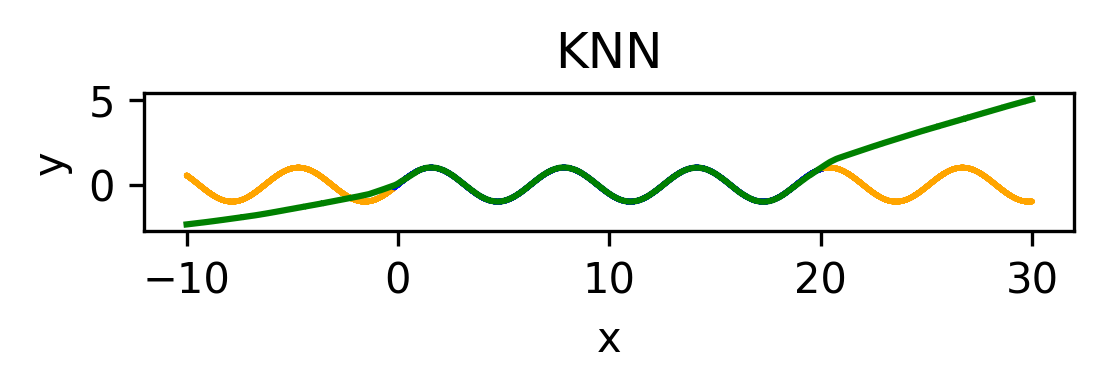

Split  Coverage
0   test       0.3
1  train      95.4
2  valid      94.5

std03:


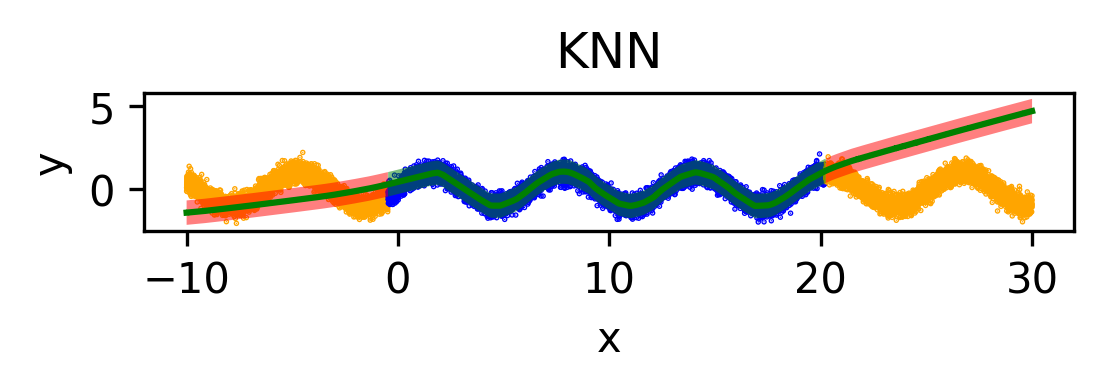

Split  Coverage
0   test      26.8
1  train      98.3
2  valid      98.3

std06:


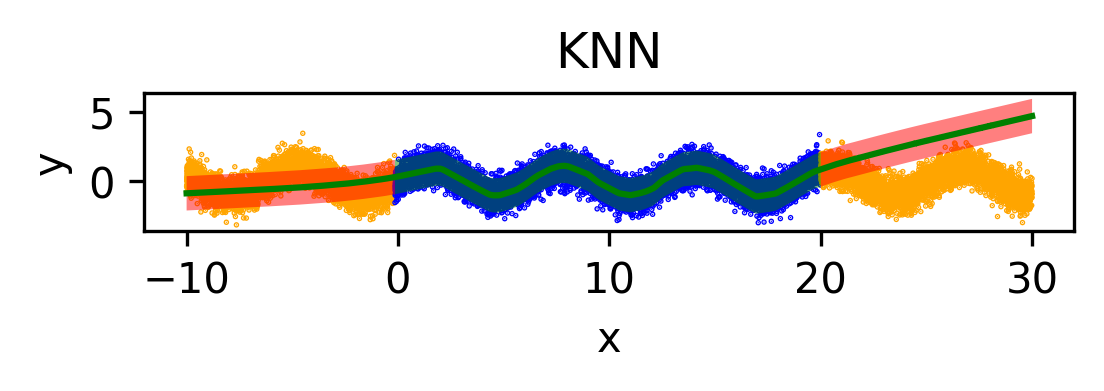

Split  Coverage
0   test      46.7
1  train      95.4
2  valid      95.8

In [93]:
evaluate_all_ae_models(
    pred_df_dict=ae_pred_df_dict, pi_name="KNN", pi_function=knn_prediction_interval, save_images=True, with_ci=True, only_pi=True
)

### Weighted

std00:
0
6.16564851784128e-07


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


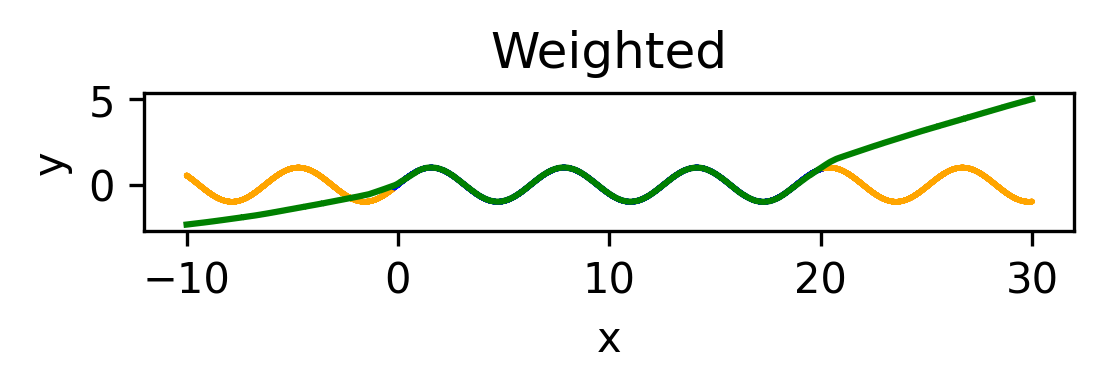

Split  Coverage
0   test       0.2
1  train      96.9
2  valid      97.2

std03:
0
4.008152776591608e-06


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


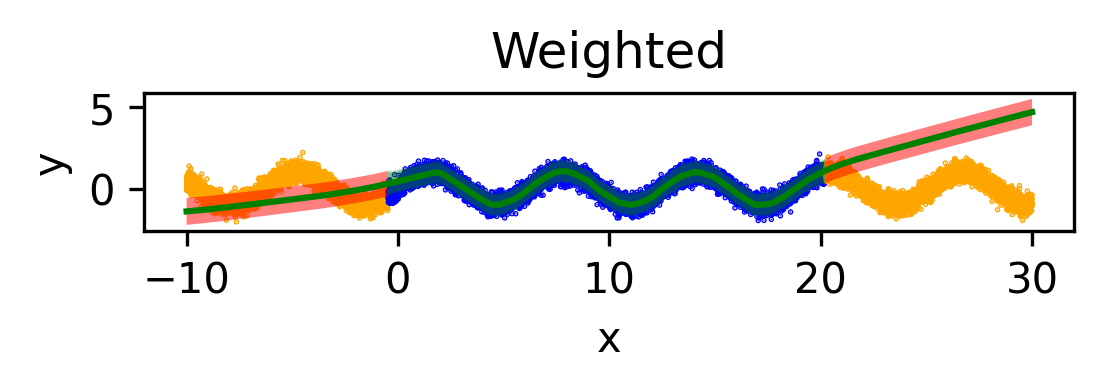

Split  Coverage
0   test      28.6
1  train      96.4
2  valid      97.2

std06:
0
6.326413827222331e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


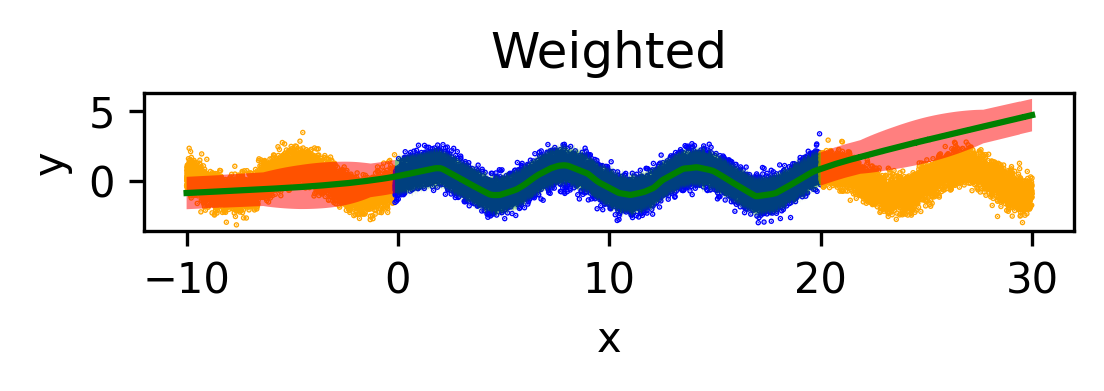

Split  Coverage
0   test      49.1
1  train      96.5
2  valid      97.2

In [94]:
evaluate_all_ae_models(
    pred_df_dict=ae_pred_df_dict, pi_name="Weighted", pi_function=weighted_prediction_interval, save_images=True, with_ci=True, only_pi=True
)

### Conditional Gaussian 

std00:


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 151.24it/s]


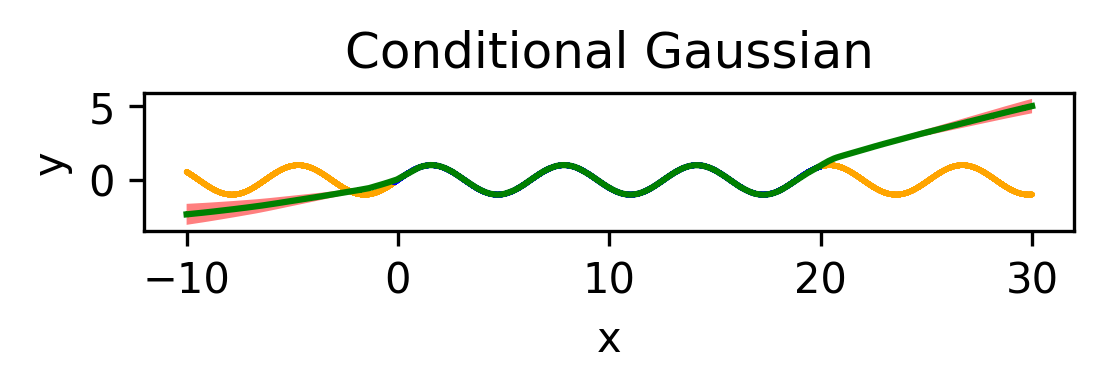

Split  Coverage
0   test       1.8
1  train      93.4
2  valid      92.5

std03:


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 117.00it/s]


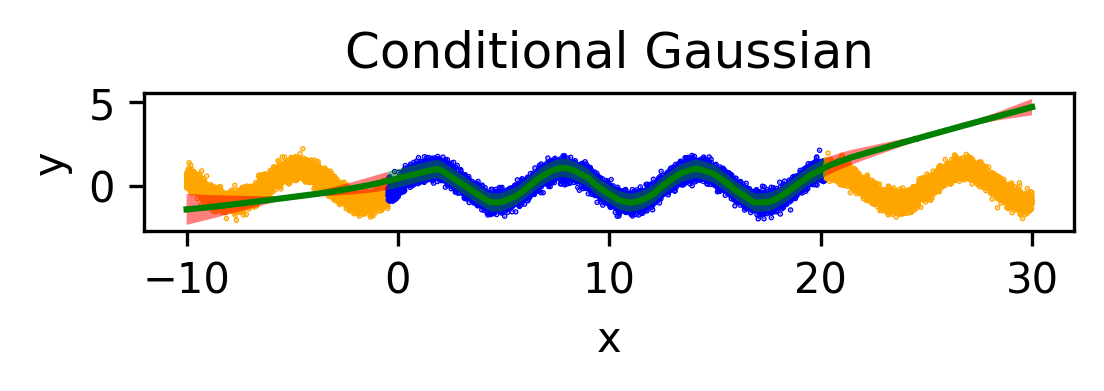

Split  Coverage
0   test       8.0
1  train      92.8
2  valid      92.7

std06:


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 134.23it/s]


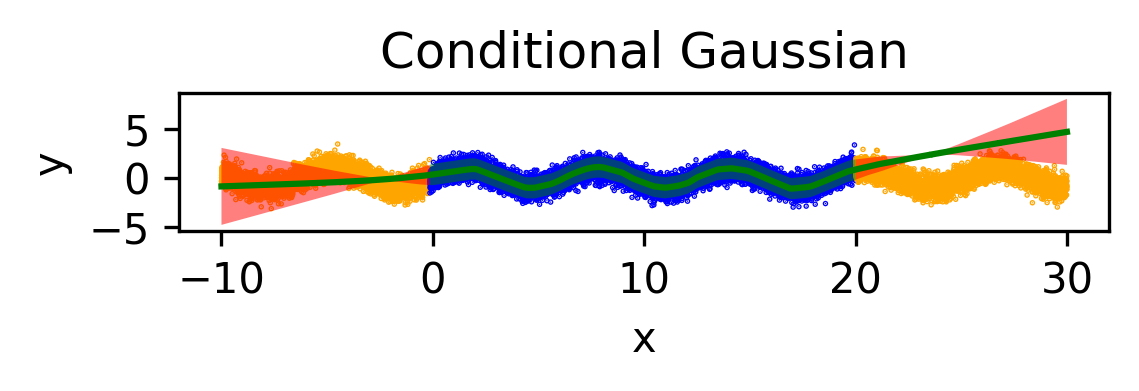

Split  Coverage
0   test       9.7
1  train      92.5
2  valid      92.4

In [95]:
evaluate_all_ae_models(
    pred_df_dict=ae_pred_df_dict, pi_name="Conditional Gaussian", pi_function=cond_gauss_prediction_interval, save_images=True, with_ci=True, only_pi=True
)

### Gaussian Copula

std00:


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.02it/s]


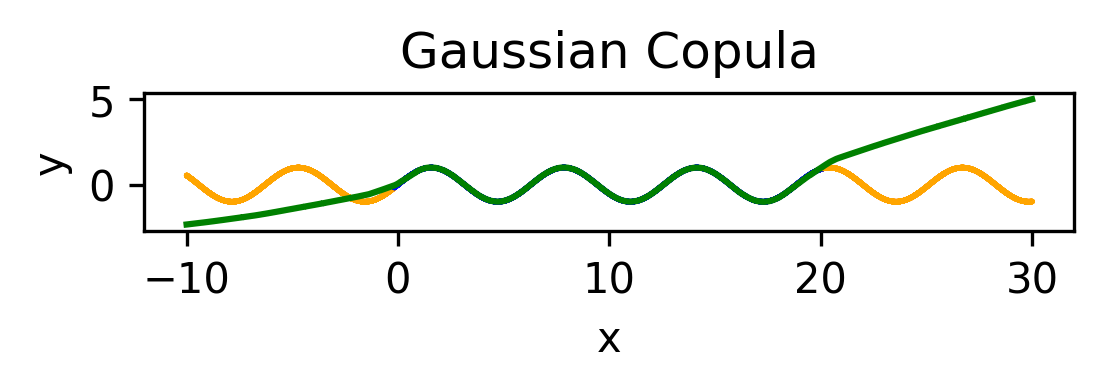

Split  Coverage
0   test       0.3
1  train      95.8
2  valid      94.8

std03:


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.92it/s]


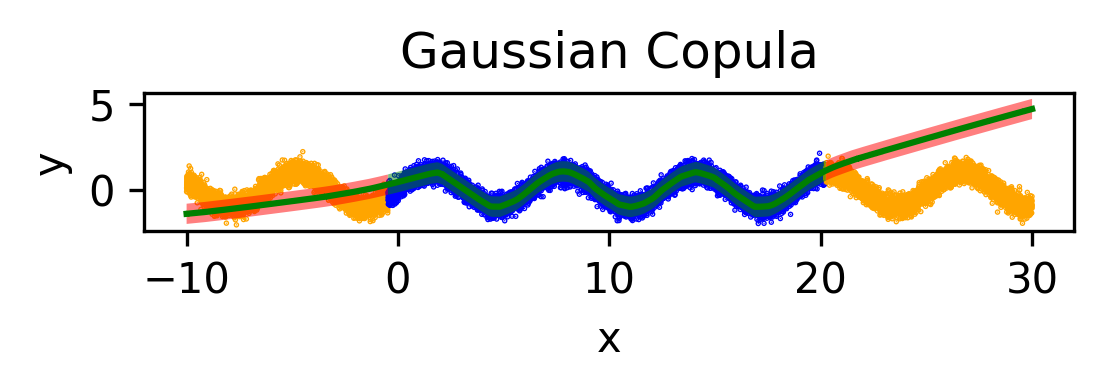

Split  Coverage
0   test      21.4
1  train      94.6
2  valid      95.1

std06:


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.51it/s]


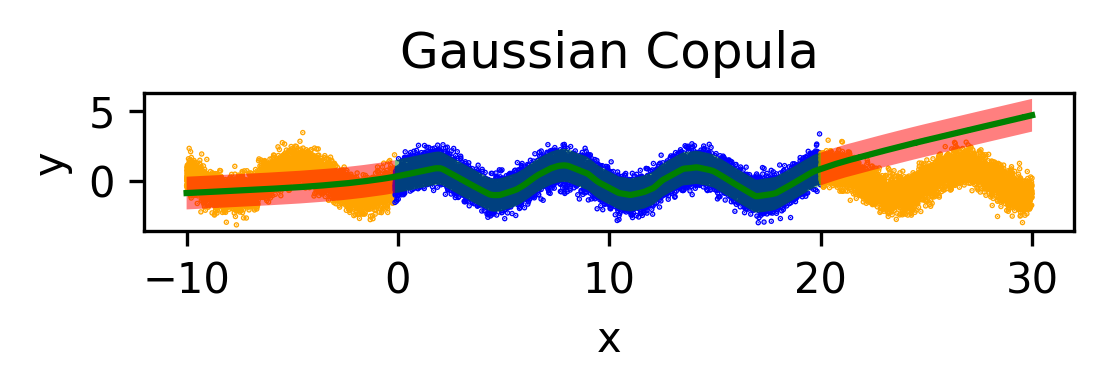

Split  Coverage
0   test      44.9
1  train      94.4
2  valid      95.0

In [96]:
evaluate_all_ae_models(
    pred_df_dict=ae_pred_df_dict, pi_name="Gaussian Copula", pi_function=gauss_copula_prediction_interval, save_images=True, with_ci=True, only_pi=True
)

## Train GPR

In [25]:
def model_training_gpr(
    predictors, pred_cols, train_df, valid_df, seed):
    from tqdm import tqdm
    import time
    set_seed(seed)
    
    # Get data
    train_X, train_y = (
        train_df[predictors].values.astype('float32'), train_df[pred_cols].values.astype('float32'))
    valid_X, valid_y = (
        valid_df[predictors].values.astype('float32'), valid_df[pred_cols].values.astype('float32'))
    
#     plt.scatter(train_X, train_y)
    
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(train_X)
    train_X, valid_X = (
        scaler.transform(train_X), scaler.transform(valid_X)
    )
    start = time.time()
    
#     import sklearn.gaussian_process as gp
#     kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
#     gpr = gp.GaussianProcessRegressor(
#         kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True, random_state=seed
#     )
    
#     from sklearn.gaussian_process import GaussianProcessRegressor
#     from sklearn.gaussian_process.kernels import ExpSineSquared
#     from sklearn.gaussian_process.kernels import WhiteKernel
#     kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(
#         1e-1
#     )
#     gpr = GaussianProcessRegressor(kernel=kernel)

    kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
        noise_level=1e-2, noise_level_bounds=(1e-10, 1e1)
    )
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)

    
    # Train GPR
    print(f"Training model...")
    gpr.fit(train_X, train_y)
    print(f"Training took {time.time()-start}s.")
    
    # GPR Debugger
    y_mean, y_std = gpr.predict(train_X, return_std=True)
#     plt.plot(train_X, train_y, label="Expected signal")
    plt.scatter(x=train_X, y=train_y, color="black", alpha=0.4, label="Observations")
    plt.errorbar(train_X, y_mean, y_std)
    plt.legend()
    plt.xlabel("X")
    plt.ylabel("y")
    _ = plt.title(
        (
            f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
            f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}"
        ),
        fontsize=8,
    )
    return gpr, scaler

def model_prediction_gpr(gpr, scaler, all_df, predictors, pred_cols, ood_lab, save_images=False):
    # Get predictions
    x = all_df[predictors].values.astype('float32')
    x = scaler.transform(x)
    y_pred, ue = gpr.predict(x, return_std=True)
    all_df["y_pred"], all_df["ue"] = y_pred, ue
    
    # Get CI
    from scipy.stats import norm
    ci = all_df["ue"] * norm.ppf(0.975) #95% of samples should fall between 2 std
    all_df["ci"] = ci
    
    # Show relationship between delta and mae
    all_df["pe"] = all_df[pred_cols[0]]-all_df["y_pred"]
    all_df = all_df.sort_values(by="x")
    plot_error_and_uncertainty(
        df=all_df, pe_lab="pe", ue_lab="ue", split_lab="split", xlabel="Std", ci_lab="ci", save_images=save_images)
    
#     print((df["delta"]<df["ci"]).sum()/len(df))
    
    # Show predictions as a line with CI
    plot_predictions(
        all_df, x_lab=predictors, y_lab=pred_cols, ood_lab=ood_lab, pe_lab="pe",
        ue_lab="ue", pred_lab="y_pred", ci_lab="ci", ylabel="Std", xmin=0, xmax=20
    )
    
    return all_df

def train_all_gpr_models(
    df_dict, checkpoint_name, x_col="x", y_col="y", split_col="split", ood_col="ood_label", seed=seed, 
    fp_checkpoint_dir=fp_checkpoint_dir, save_images=False):
    model_dict, scaler_dict, pred_df_dict = {}, {}, {}
    fp_all_model_folder = os.path.join(fp_checkpoint_dir, checkpoint_name)
    if not os.path.exists(fp_all_model_folder):
        os.makedirs(fp_all_model_folder)
    for df_label, df in tqdm(df_dict.items(), total=len(df_dict)):
        print(f"{df_label}:")
        fp_cur_model_folder = os.path.join(fp_all_model_folder, df_label)
        fp_cur_model_scaler_file = os.path.join(fp_cur_model_folder, f"{df_label}_scaler.joblib")
        fp_cur_model_file = os.path.join(fp_cur_model_folder, f"{df_label}.joblib")
        fp_cur_model_pred_df = os.path.join(fp_cur_model_folder, f"{df_label}.csv")
        if not os.path.exists(fp_cur_model_folder):
            os.makedirs(fp_cur_model_folder)
        (train_df, valid_df) = (
            df[df[split_col]=="train"], df[df[split_col]=="valid"]
        )
        from joblib import dump
        if not os.path.exists(fp_cur_model_file):
            gpr, scaler = model_training_gpr(
            predictors=[x_col], pred_cols=[y_col], train_df=train_df, valid_df=valid_df, seed=seed)
            dump(gpr, fp_cur_model_file) 
            dump(scaler,fp_cur_model_scaler_file) 
        else:
            print("Existing model in folder!")
            continue
        model_dict[df_label] = gpr
        scaler_dict[df_label] = scaler
        pred_df = model_prediction_gpr(
            gpr=gpr, scaler=scaler, all_df=df, predictors=[x_col], pred_cols=[y_col], ood_lab=ood_col, save_images=save_images)
        pred_df_dict[df_label] = pred_df
        df.to_csv(fp_cur_model_pred_df, index=False)
    return model_dict, scaler_dict, pred_df_dict

def load_all_gpr_models(checkpoint_name, fp_checkpoint_dir=fp_checkpoint_dir):
    model_dict, scaler_dict, pred_df_dict = {}, {}, {}
    fp_all_model_folder = os.path.join(fp_checkpoint_dir, checkpoint_name)
    if not os.path.exists(fp_all_model_folder):
        print("Model folder does not exist!")
        return
    model_folders = os.listdir(fp_all_model_folder)
    model_folders.sort()
    for df_label in model_folders:
        fp_cur_model_folder = os.path.join(fp_all_model_folder, df_label)
        fp_cur_model_scaler_file = os.path.join(fp_cur_model_folder, f"{df_label}_scaler.joblib")
        fp_cur_model_file = os.path.join(fp_cur_model_folder, f"{df_label}.joblib")
        fp_cur_model_pred_df = os.path.join(fp_cur_model_folder, f"{df_label}.csv")
        from joblib import load
        gpr = load(fp_cur_model_file) 
        scaler = load(fp_cur_model_scaler_file)
        pred_df = pd.read_csv(fp_cur_model_pred_df)
        model_dict[df_label] = gpr
        pred_df_dict[df_label] = pred_df
        scaler_dict[df_label] = scaler
    return model_dict, scaler_dict, pred_df_dict

def evaluate_all_gpr_models(df_dict, scaler_dict, model_dict, x_col="x", y_col="y", split_col="split", ood_col="ood_label"):
    for df_label, df in df_dict.items():
        gpr = model_dict[df_label]
        print(f"{df_label}:")
        df = df_dict[df_label]
        scaler = scaler_dict[df_label]
        (train_df, valid_df) = (
            df[df[split_col]=="train"], df[df[split_col]=="valid"]
        )
        pred_df = model_prediction_gpr(
            gpr=gpr, scaler=scaler, all_df=df, predictors=[x_col], pred_cols=[y_col], ood_lab=ood_col
        )

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

std00:
Existing model in folder!
std03:
Existing model in folder!
std06:
Training model...
Training took 100.11658573150635s.


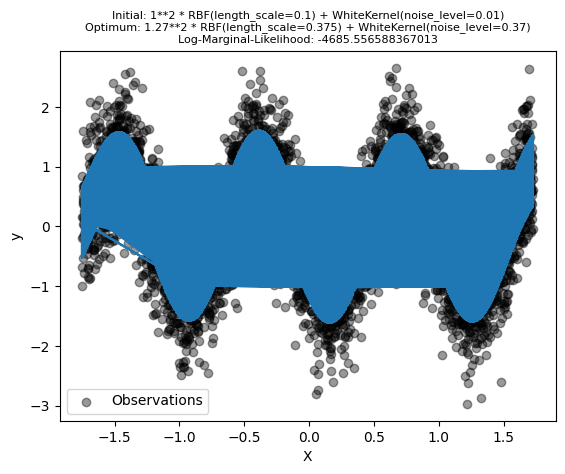

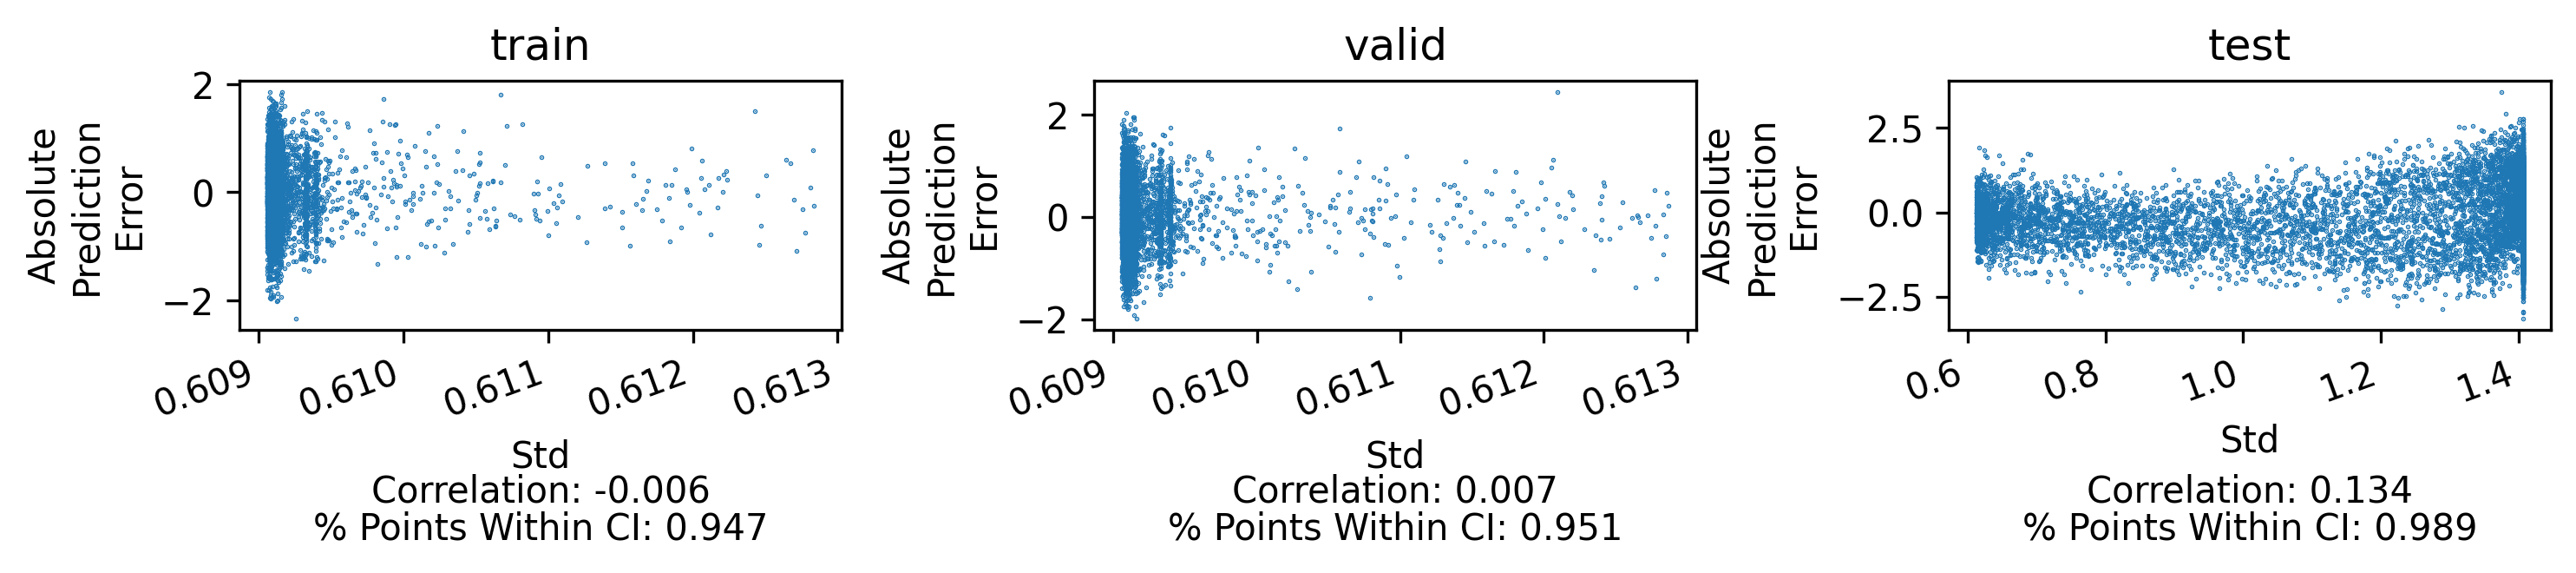

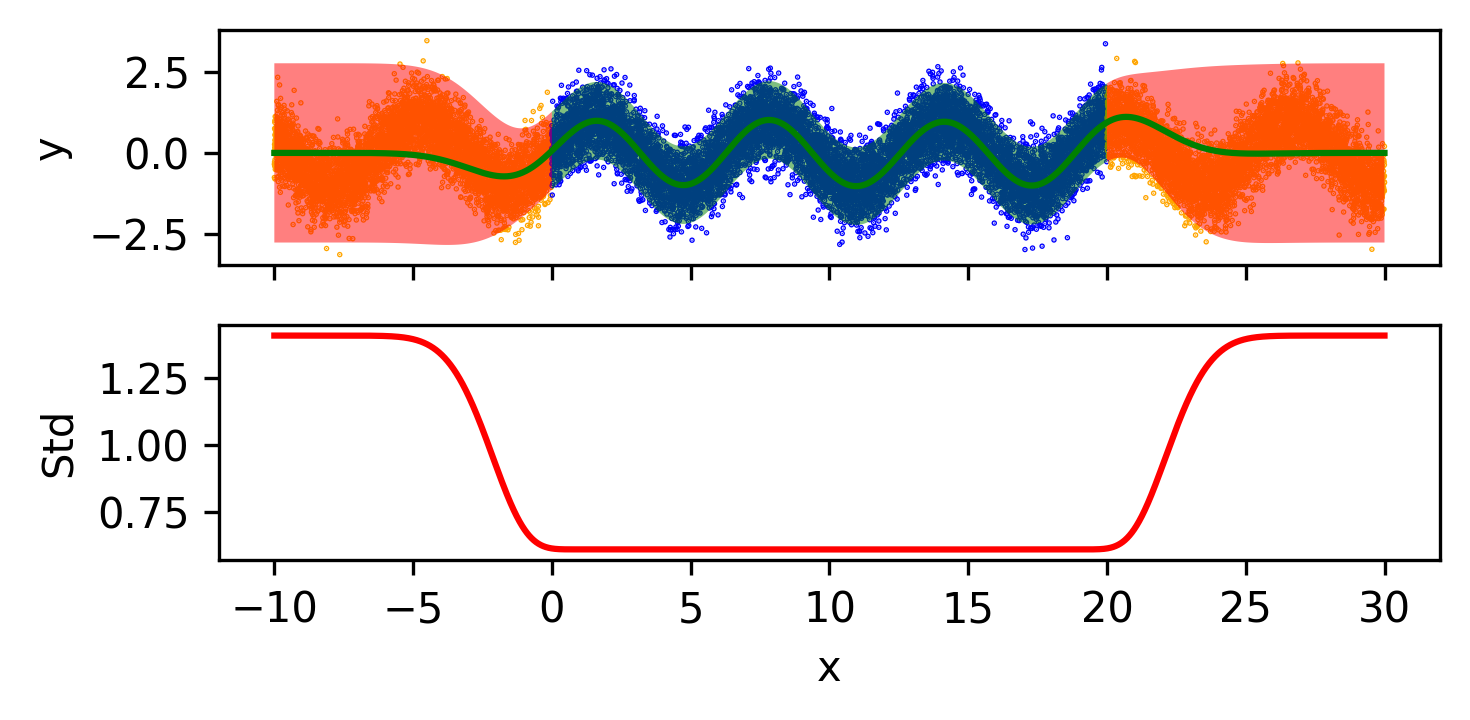

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:46<00:00, 35.64s/it]


In [87]:
gpr_model_dict, scaler_dict, gpr_pred_df_dict = train_all_gpr_models(
    df_dict={"std00":df_std00, "std03":df_std03, "std06":df_std06}, 
    checkpoint_name="gpr_models"
) 

In [88]:
gpr_model_dict, scaler_dict, gpr_pred_df_dict = load_all_gpr_models(checkpoint_name="gpr_models")

std00:


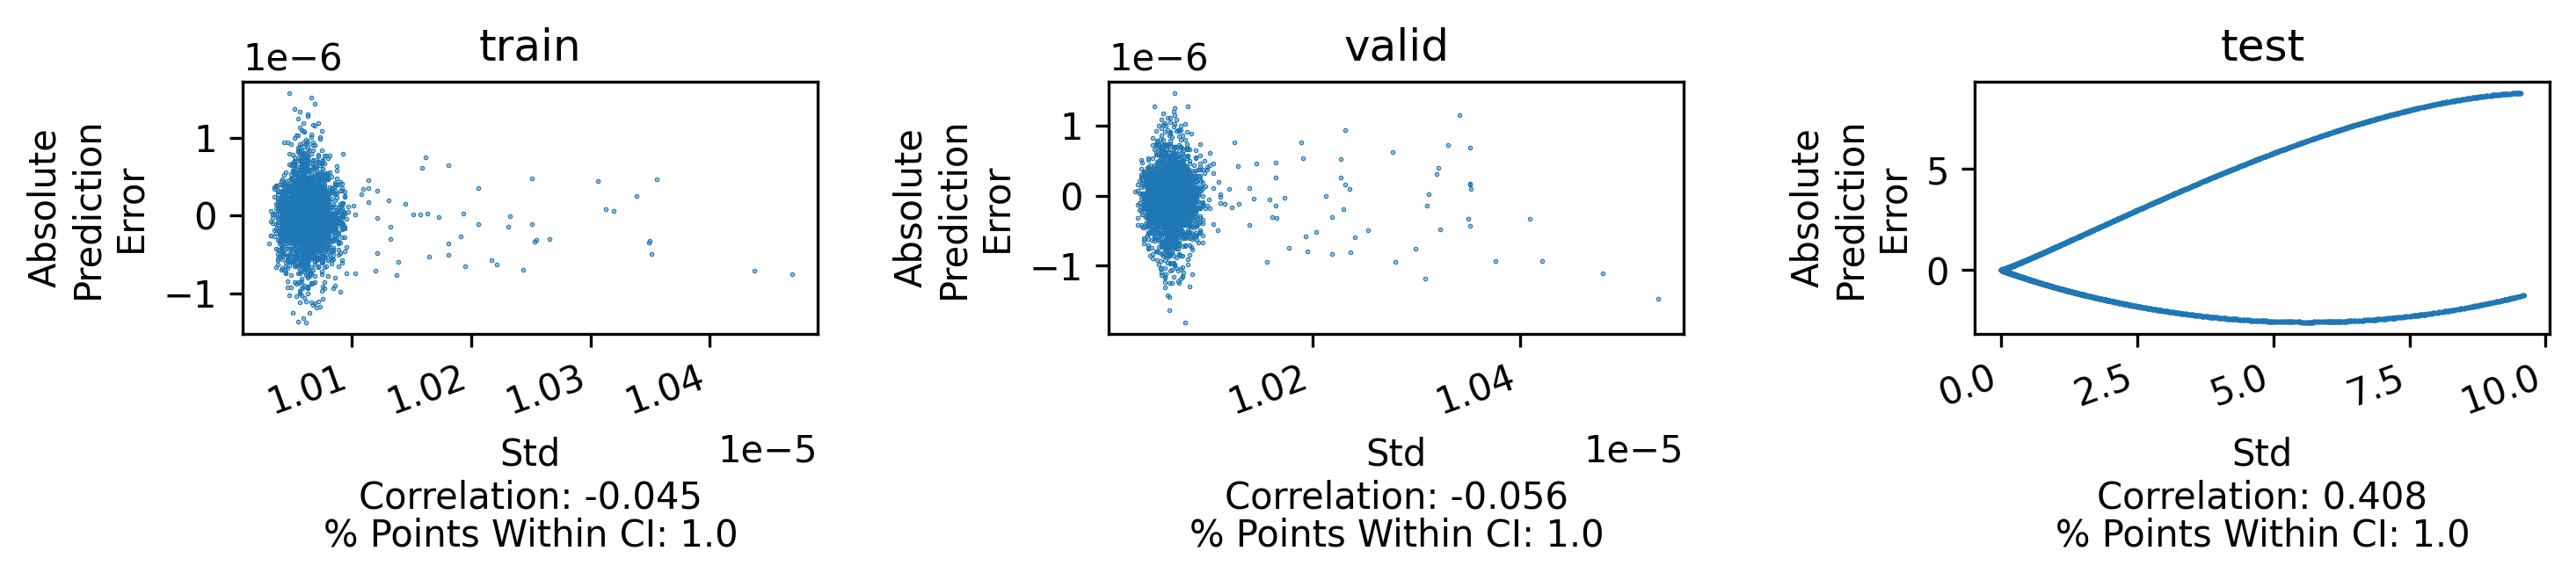

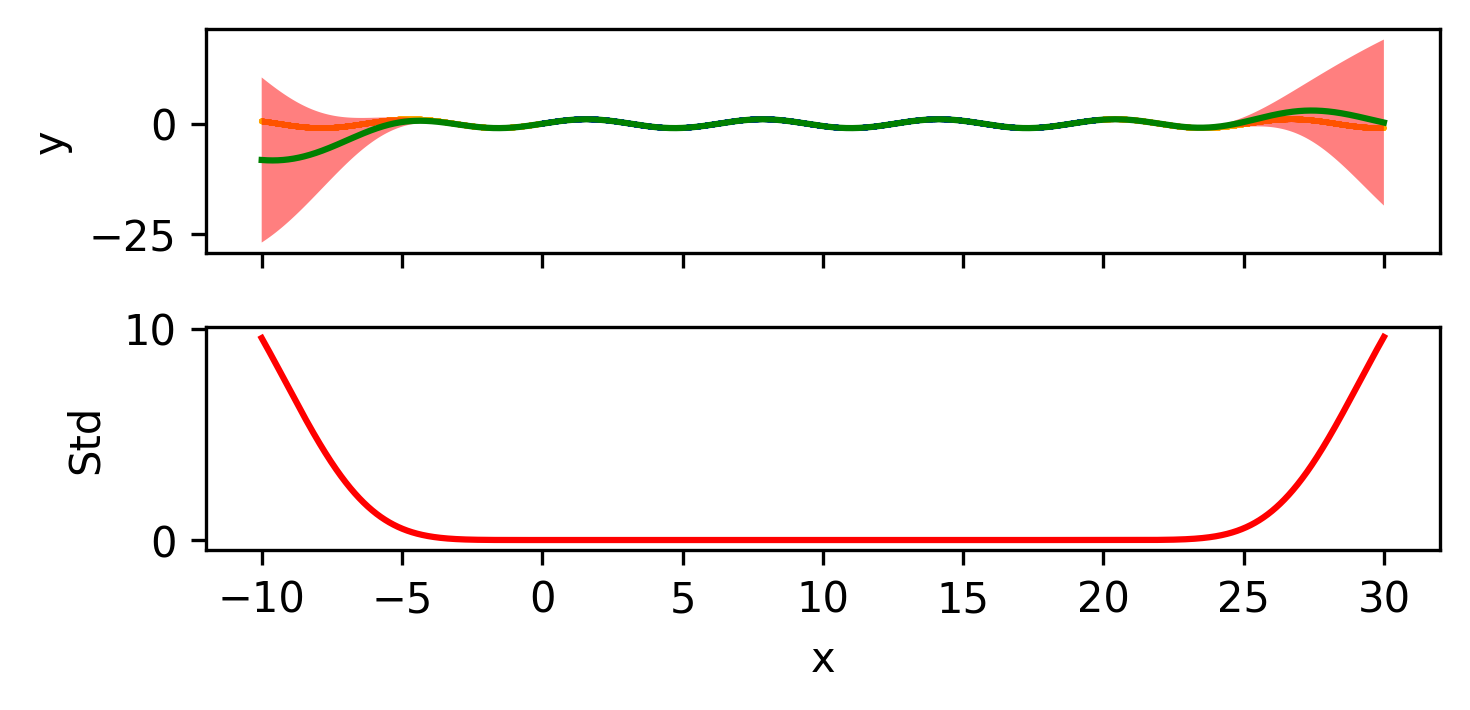

std03:


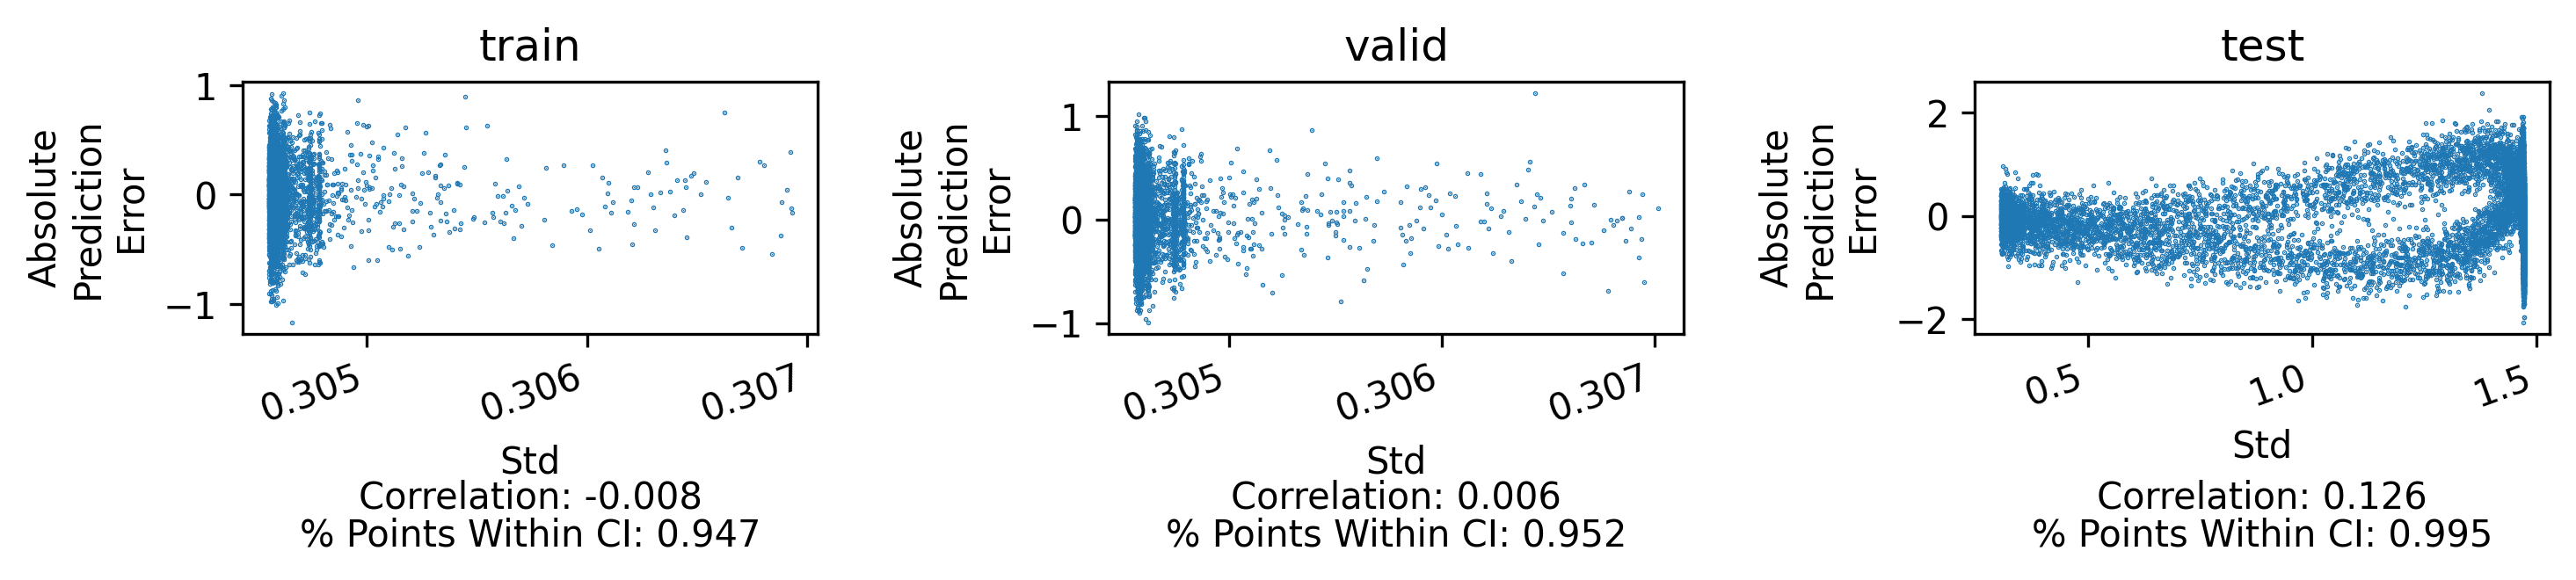

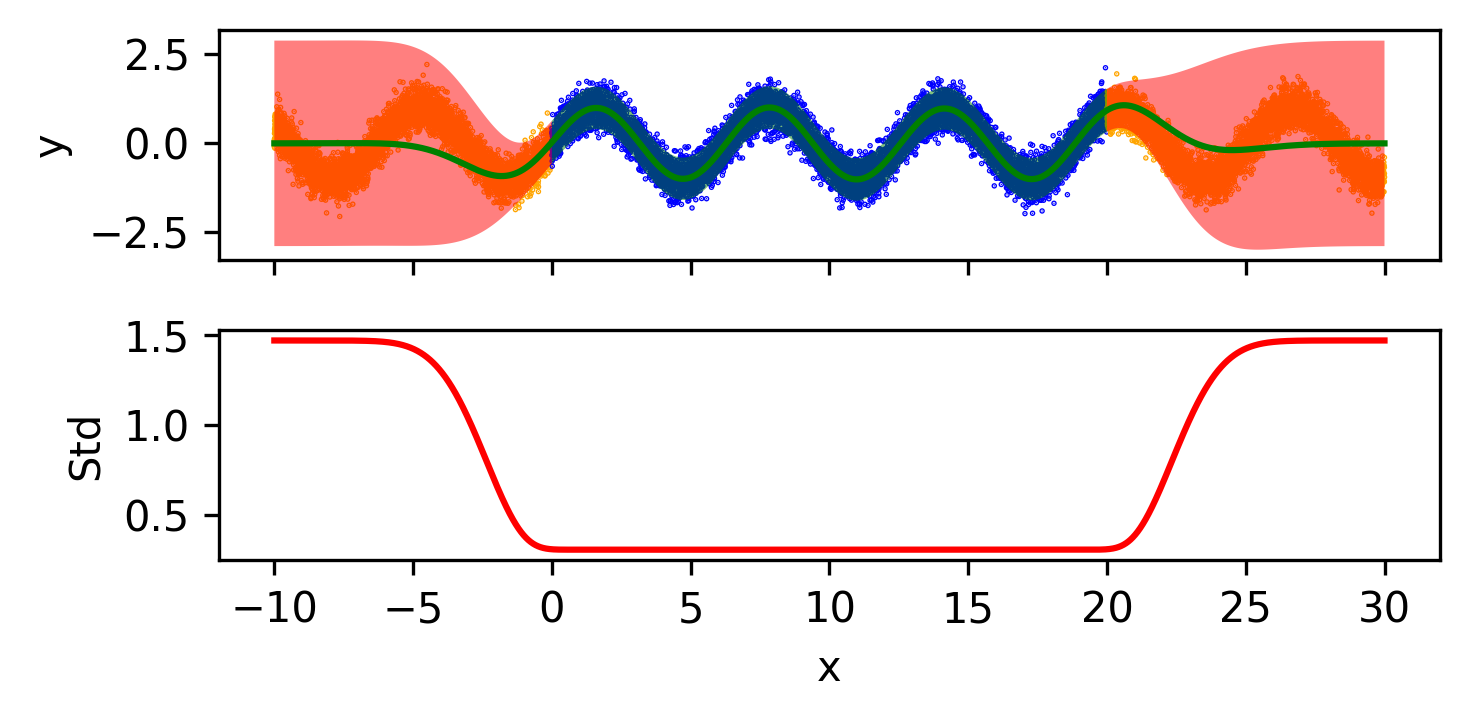

std06:


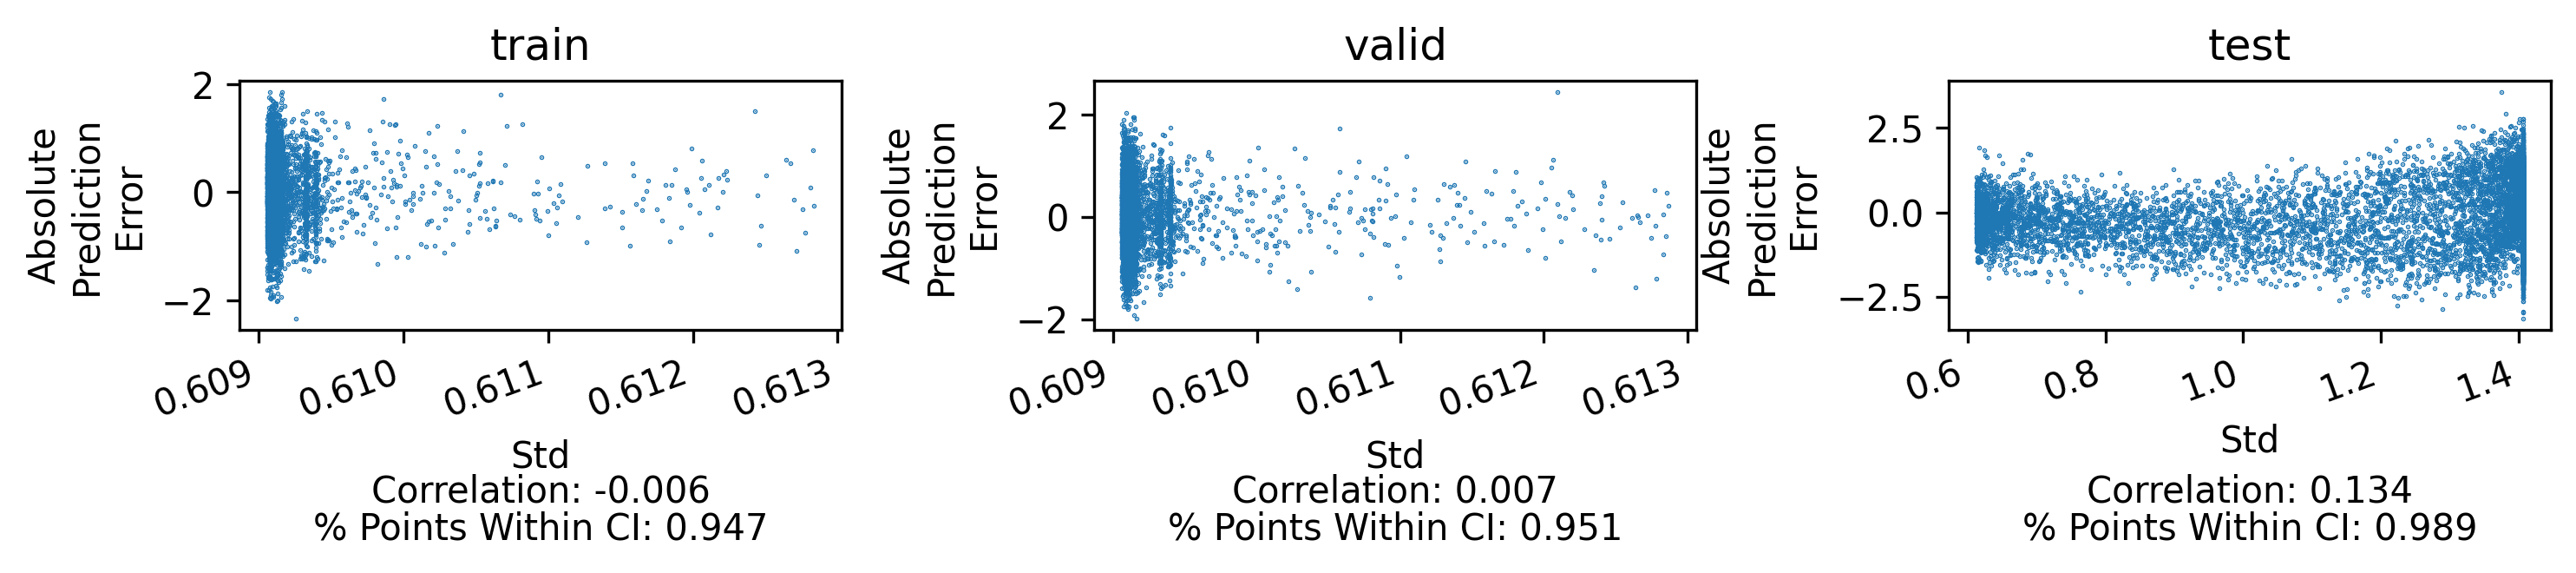

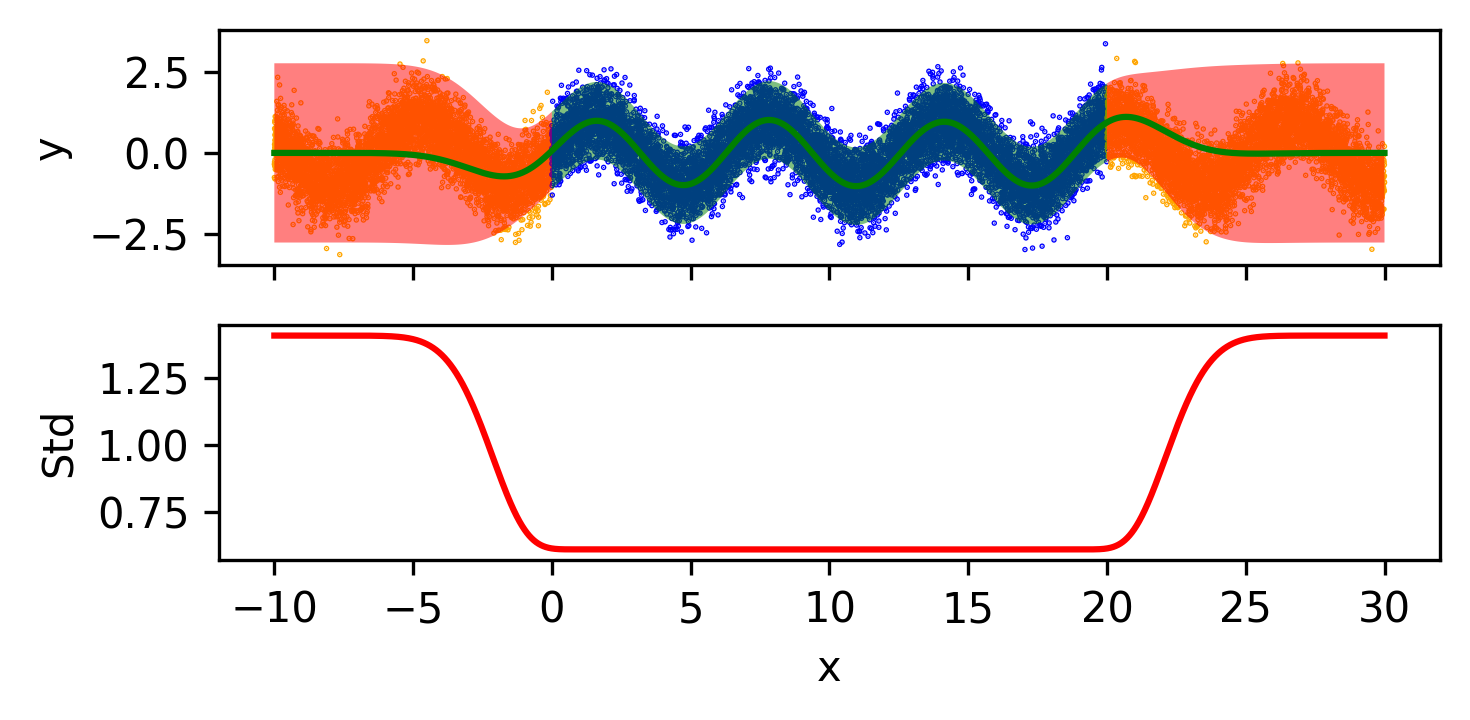

In [89]:
evaluate_all_gpr_models(
    df_dict={"std00":df_std00, "std03":df_std03, "std06":df_std06}, 
    model_dict=gpr_model_dict, scaler_dict=scaler_dict
)

## Train MC Dropout Model

In [33]:
def set_seed(seed):
    import os
    import random
    tf.config.experimental.enable_op_determinism()
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def display_history(history, show_acc=False):
    if show_acc:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 2.5))
        axes[0].plot(history.history['loss'])
        axes[0].plot(history.history['val_loss'])
        axes[0].set_title('Model Loss')
        axes[0].set_ylabel('Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].legend(['Train', 'Val'], loc='upper left')
        axes[1].plot(history.history['accuracy'])
        axes[1].plot(history.history['val_accuracy'])
        axes[1].set_title('Model Accuracy')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['Train', 'Val'], loc='upper left')
        axes[2].plot(history.history['f1_score'])
        axes[2].plot(history.history['val_f1_score'])
        axes[2].set_title('Model F1 Score')
        axes[2].set_ylabel('F1 Score')
        axes[2].set_xlabel('Epoch')
        axes[2].legend(['Train', 'Val'], loc='upper left')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 2.5))
        axes.plot(history.history['loss'])
        axes.plot(history.history['val_loss'])
        axes.set_title('Model Loss')
        axes.set_ylabel('Loss')
        axes.set_xlabel('Epoch')
        axes.legend(['Train', 'Val'], loc='upper left')
    plt.tight_layout()
    plt.show()

class Dropout_Regressor:
    def __init__(self, width, predictors, output_features):
        from keras.layers import Dense, Dropout
        self.predictors = predictors
        self.output_features = output_features
        self.num_predictors = len(self.predictors)
        self.num_outputs = len(self.output_features)
        self.width = width
        
        # Instantiate model layers
        self.inputs = tf.keras.Input(shape=(self.num_predictors,))
        self.normalisation = tf.keras.layers.Normalization(name="normalisation")
        self.encoder = tf.keras.Sequential([
            Dense(self.width, activation="relu"),
            Dense(self.width, activation="relu"),
        ], name="encoder")
        self.dropout = Dropout(rate=0.2, name="dropout")
        self.regressor = tf.keras.Sequential([
            Dense(self.width, activation="relu"),
            Dense(self.num_outputs)
        ], name="regressor")

    # Smote is external
    def train_regressor(
        self, train_X, train_y, val_X, val_y, batch_size, max_epochs, verbose, patience):
        from tensorflow.keras.callbacks import EarlyStopping
        # Fit the standard scaler 
        self.normalisation.adapt(train_X)
        
        # Define regressor
        pred = self.normalisation(self.inputs)
        pred = self.encoder(pred)
        pred = self.dropout(pred)
        pred = self.regressor(pred)
        self.predictor = tf.keras.Model(inputs=self.inputs, outputs=pred, name="regression_model")
        # Train classifier
        self.predictor.compile(
            loss="mse",
            optimizer=tf.keras.optimizers.Adam()
        )
        es = EarlyStopping(
            monitor='val_loss', mode='min', verbose=1, patience=patience, restore_best_weights=True)
        self.predictor_history = self.predictor.fit(
            train_X, train_y, 
            epochs=max_epochs, 
            validation_data=(val_X, val_y),
            verbose=verbose,
            batch_size=batch_size,
            callbacks=[es],
        )
        print("- Regressor Training History")
        display_history(self.predictor_history)
        best_index = np.argmin(self.predictor_history.history['val_loss'])
        return (
            self.predictor_history.history['val_loss'][best_index], 
            best_index
        )

    def predict(self, inputs, activate_dropout, T, seed):
        set_seed(seed)
        outputs = []
        for _ in range(T):
            # Normalise
            norm_output = self.normalisation(inputs)
            # Encode
            encoder_output = self.encoder(norm_output)
            # Dropout
            dropout_output = self.dropout(encoder_output, training=activate_dropout)
            # Get forecast result
            regressor_output = self.regressor(dropout_output)
            
            outputs.append(regressor_output.numpy().flatten())
            
        outputs = np.array(outputs).transpose((1, 0))
#         print(outputs.shape)
        mean_output = np.mean(outputs, axis=-1)
#         print(mean_output.shape)
        std_output = np.std(outputs, axis=-1, ddof=1)
#         print(std_output.shape)
        
        return mean_output, std_output
        
def save_dropout_model(model, name, fp_checkpoints, override=False):
    import pickle
    model_folder = os.path.join(fp_checkpoints, name)
    if os.path.exists(model_folder):
        print("Model checkpoint already exists!")
        if not override:
            return
    else:
        os.makedirs(model_folder)
    
    # Save Parameters
    parameters_to_save = dict(
        predictors = model.predictors,
        output_features = model.output_features,
        width = model.width
    )   
    parameter_filename = os.path.join(fp_checkpoints, name, "parameters.pickle")
    with open(parameter_filename, 'wb') as handle:
        pickle.dump(parameters_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Save Model
    inputs = model.inputs
    normalisation_output = model.normalisation(inputs)
    encoder_output = model.encoder(normalisation_output)
    dropout_output = model.dropout(encoder_output)
    regressor_output = model.regressor(dropout_output)
    model = tf.keras.Model(inputs, [regressor_output])
    model_filename = os.path.join(fp_checkpoints, name, "model.h5")
    model.save(model_filename)
    print("Model saved!")

def load_dropout_model(name, fp_checkpoints): 
    import pickle
    model_folder = os.path.join(fp_checkpoints, name)
    parameter_filename = os.path.join(fp_checkpoints, name, "parameters.pickle")
    model_filename = os.path.join(fp_checkpoints, name, "model.h5")
    
    if not os.path.exists(model_folder):
        print("model checkpoint does not exist!")
        return
    model = tf.keras.models.load_model(model_filename)
    with open(parameter_filename, 'rb') as handle:
        parameters = pickle.load(handle)
    
    ae_regressor = Dropout_Regressor(
        parameters["width"], parameters["predictors"], parameters["output_features"])
    ae_regressor.normalisation = model.get_layer("normalisation")
    ae_regressor.encoder = model.get_layer("encoder")
    ae_regressor.dropout = model.get_layer("dropout")
    ae_regressor.regressor = model.get_layer("regressor")
    
    return ae_regressor

def model_training_dropout(
    width, predictors, pred_cols, train_df, valid_df, seed,
    batch_size=128, max_epochs=5000, verbose=1, patience=10):
    
    from tqdm import tqdm
    import time
    set_seed(seed)
    
    # Get data
    train_X, train_y = (
        train_df[predictors].values.astype('float32'), train_df[pred_cols].values.astype('float32'))
    valid_X, valid_y = (
        valid_df[predictors].values.astype('float32'), valid_df[pred_cols].values.astype('float32'))
    
    # Train Regressor
    regressor = Dropout_Regressor(width, predictors, pred_cols)
    
    start = time.time()
    
    # Train Regressor
    valid_loss_regressor, best_epoch = regressor.train_regressor(
        train_X=train_X, train_y=train_y, val_X=valid_X, val_y=valid_y, 
        batch_size=batch_size, max_epochs=max_epochs, verbose=verbose, patience=patience)
    
    print(f"Training took {time.time()-start}s.")
    return regressor

def train_all_dropout_models(
    df_dict, checkpoint_name, x_col="x", y_col="y", split_col="split", ood_col="ood_label", seed=seed, 
    fp_checkpoint_dir=fp_checkpoint_dir):
    model_dict, pred_df_dict = {}, {}
    fp_all_model_folder = os.path.join(fp_checkpoint_dir, checkpoint_name)
    if not os.path.exists(fp_all_model_folder):
        os.makedirs(fp_all_model_folder)
    for df_label, df in tqdm(df_dict.items(), total=len(df_dict)):
        print(f"{df_label}:")
        fp_cur_model_folder = os.path.join(fp_all_model_folder, df_label)
        fp_cur_model_pred_df = os.path.join(fp_cur_model_folder, f"{df_label}.csv")
        if not os.path.exists(fp_cur_model_folder):
            os.makedirs(fp_cur_model_folder)
        
            (train_df, valid_df) = (
                df[df[split_col]=="train"], df[df[split_col]=="valid"]
            )
            regressor = model_training_dropout(
                width=100, predictors=[x_col], pred_cols=[y_col], train_df=train_df, valid_df=valid_df, seed=seed,
                batch_size=64, max_epochs=5000, verbose=1, patience=10)
            save_dropout_model(
                model=regressor, name=df_label, fp_checkpoints=fp_cur_model_folder, override=False)
            model_dict[df_label] = regressor
            pred_df = model_prediction_dropout(
                regressor=regressor, all_df=df, split_col="split",
                predictors=[x_col], pred_cols=[y_col], ood_lab=ood_col, 
                save_images=False, with_ci=True, seed=seed
            )
            pred_df_dict[df_label] = pred_df
            df.to_csv(fp_cur_model_pred_df, index=False)
        
        else:
            print("Model Exists!")
            continue
    return model_dict, pred_df_dict

def load_all_dropout_models(checkpoint_name, fp_checkpoint_dir=fp_checkpoint_dir):
    model_dict, pred_df_dict = {}, {}
    fp_all_model_folder = os.path.join(fp_checkpoint_dir, checkpoint_name)
    if not os.path.exists(fp_all_model_folder):
        print("Model folder does not exist!")
        return
    model_folders = os.listdir(fp_all_model_folder)
    model_folders.sort()
    for df_label in model_folders:
        fp_cur_model_folder = os.path.join(fp_all_model_folder, df_label)
        fp_cur_model_pred_df = os.path.join(fp_cur_model_folder, f"{df_label}.csv")
        regressor = load_dropout_model(name=df_label, fp_checkpoints=fp_cur_model_folder)
        pred_df = pd.read_csv(fp_cur_model_pred_df)
        model_dict[df_label] = regressor
        pred_df_dict[df_label] = pred_df
    return model_dict, pred_df_dict

def evaluate_all_dropout_models(
    df_dict, model_dict, save_images=False, with_ci=True,
    x_col="x", y_col="y", split_col="split", ood_col="ood_label", seed=seed):
    for df_label, df in df_dict.items():
        regressor = model_dict[df_label]
        print(f"{df_label}:")
        (train_df, valid_df) = (
            df[df[split_col]=="train"], df[df[split_col]=="valid"]
        )
        pred_df = model_prediction_dropout(
            regressor=regressor, all_df=df, split_col="split",
            predictors=[x_col], pred_cols=[y_col], ood_lab=ood_col, 
            save_images=save_images, with_ci=with_ci, seed=seed
        )

def model_prediction_dropout(
    regressor, all_df, split_col, predictors, pred_cols, ood_lab, save_images, with_ci, seed):
    all_df = all_df.copy()
    
    # Get predictions
    x = all_df[predictors].values.astype('float32')
    y = all_df[pred_cols].values.astype('float32')
    y_pred, ue = regressor.predict(x, activate_dropout=True, T=10, seed=seed)
    
    all_df["y_pred"], all_df["ue"] = y_pred, ue
    
    # Get CI
    from scipy.stats import norm
    ci = all_df["ue"] * norm.ppf(0.975) #95% of samples should fall between 2 std
    all_df["ci"] = ci
    
    # Show relationship between delta and mae
    all_df["pe"] = all_df[pred_cols[0]]-all_df["y_pred"]
    all_df = all_df.sort_values(by="x")
    plot_error_and_uncertainty(
        df=all_df, pe_lab="pe", ue_lab="ue", split_lab="split", xlabel="Std", ci_lab="ci", save_images=save_images)
    
    # Show predictions as a line with CI
    plot_predictions(
        all_df, x_lab=predictors, y_lab=pred_cols, ood_lab=ood_lab, pe_lab="pe",
        ue_lab="ue", pred_lab="y_pred", ci_lab="ci", ylabel="Std", xmin=0, xmax=20
    )
    
    return all_df


In [37]:
dropout_model_dict, dropout_pred_df_dict = train_all_dropout_models(
    df_dict={"std00":df_std00, "std03":df_std03, "std06":df_std06}, 
    checkpoint_name="dropout_models"
)

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2341.01it/s]

std00:
Model Exists!
std03:
Model Exists!
std06:
Model Exists!


In [30]:
dropout_model_dict, dropout_pred_df_dict = load_all_dropout_models(
    checkpoint_name="dropout_models"
)

std00:


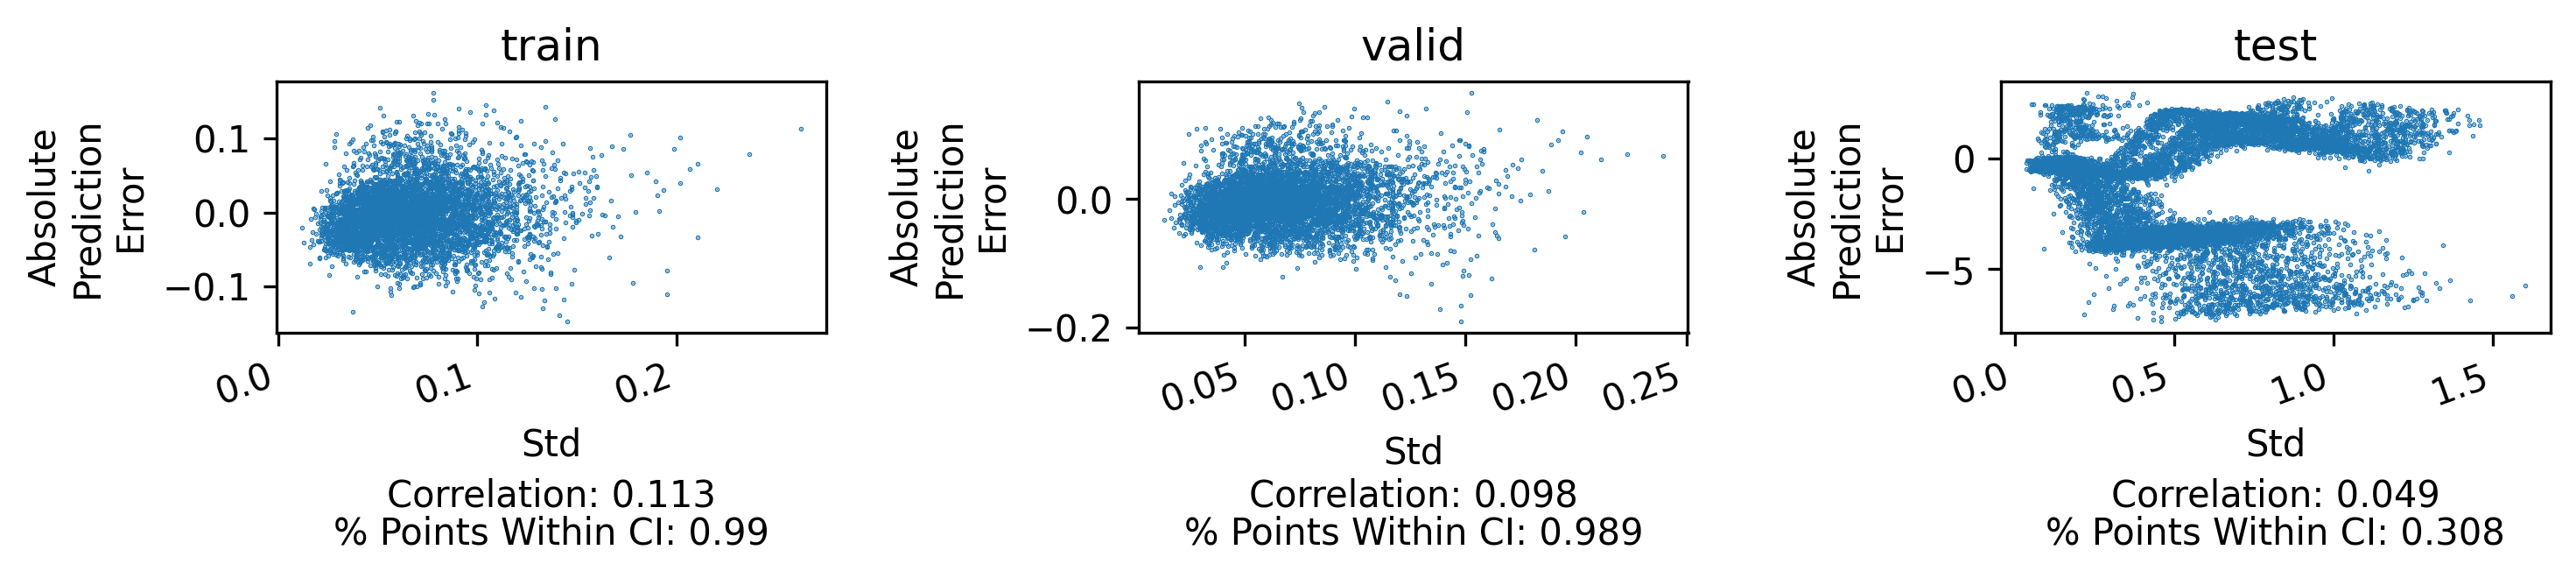

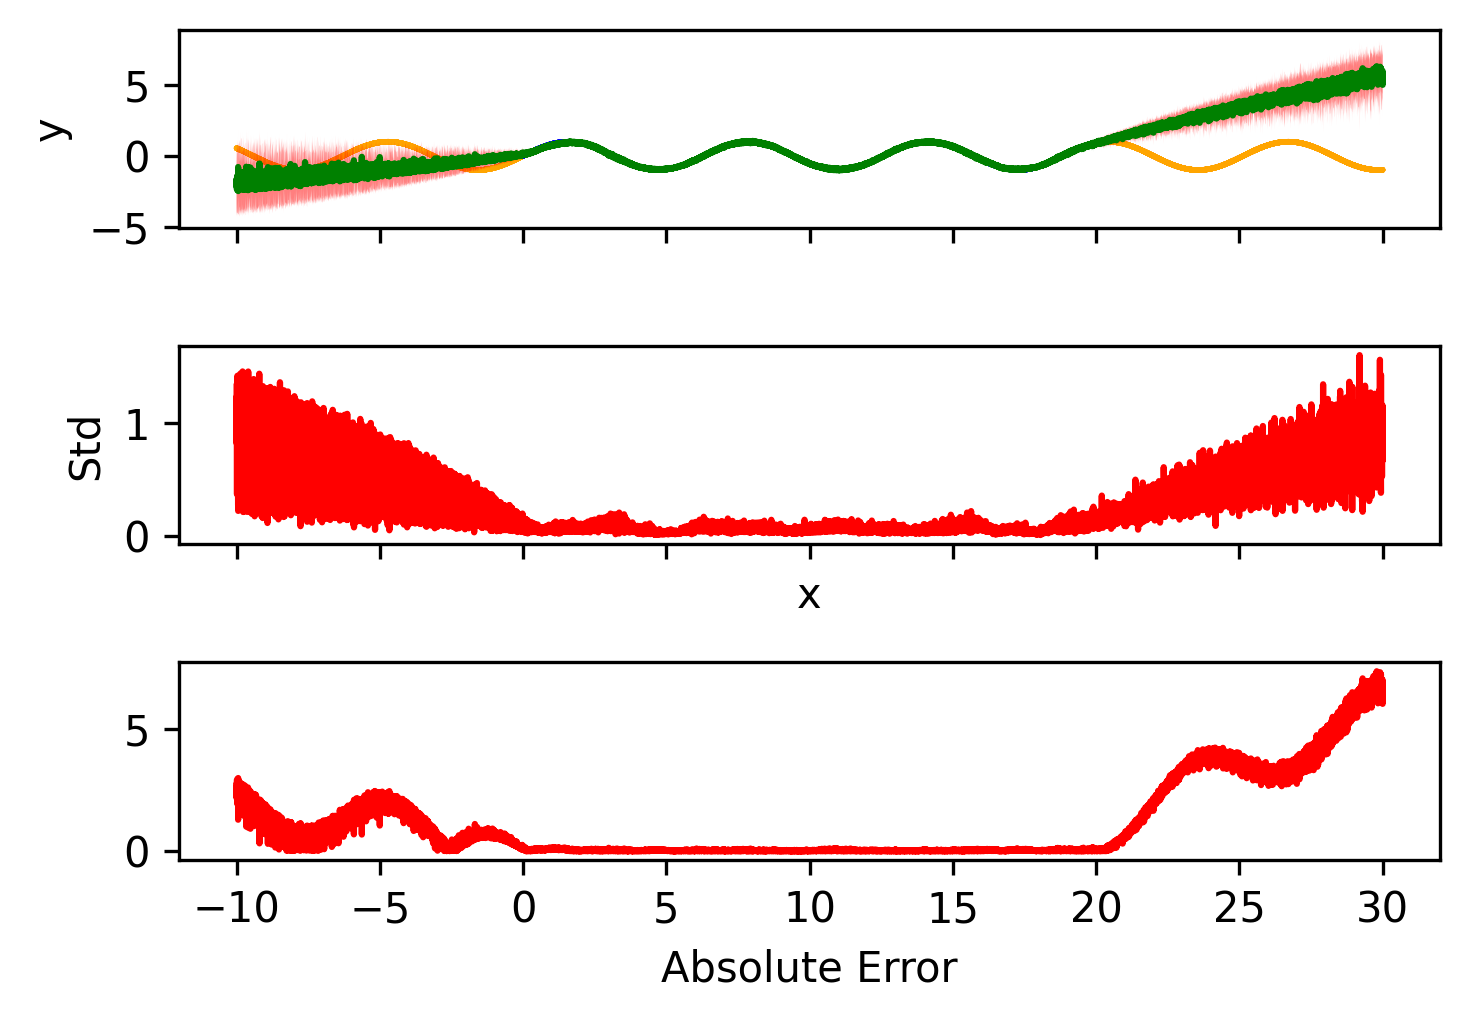

std03:


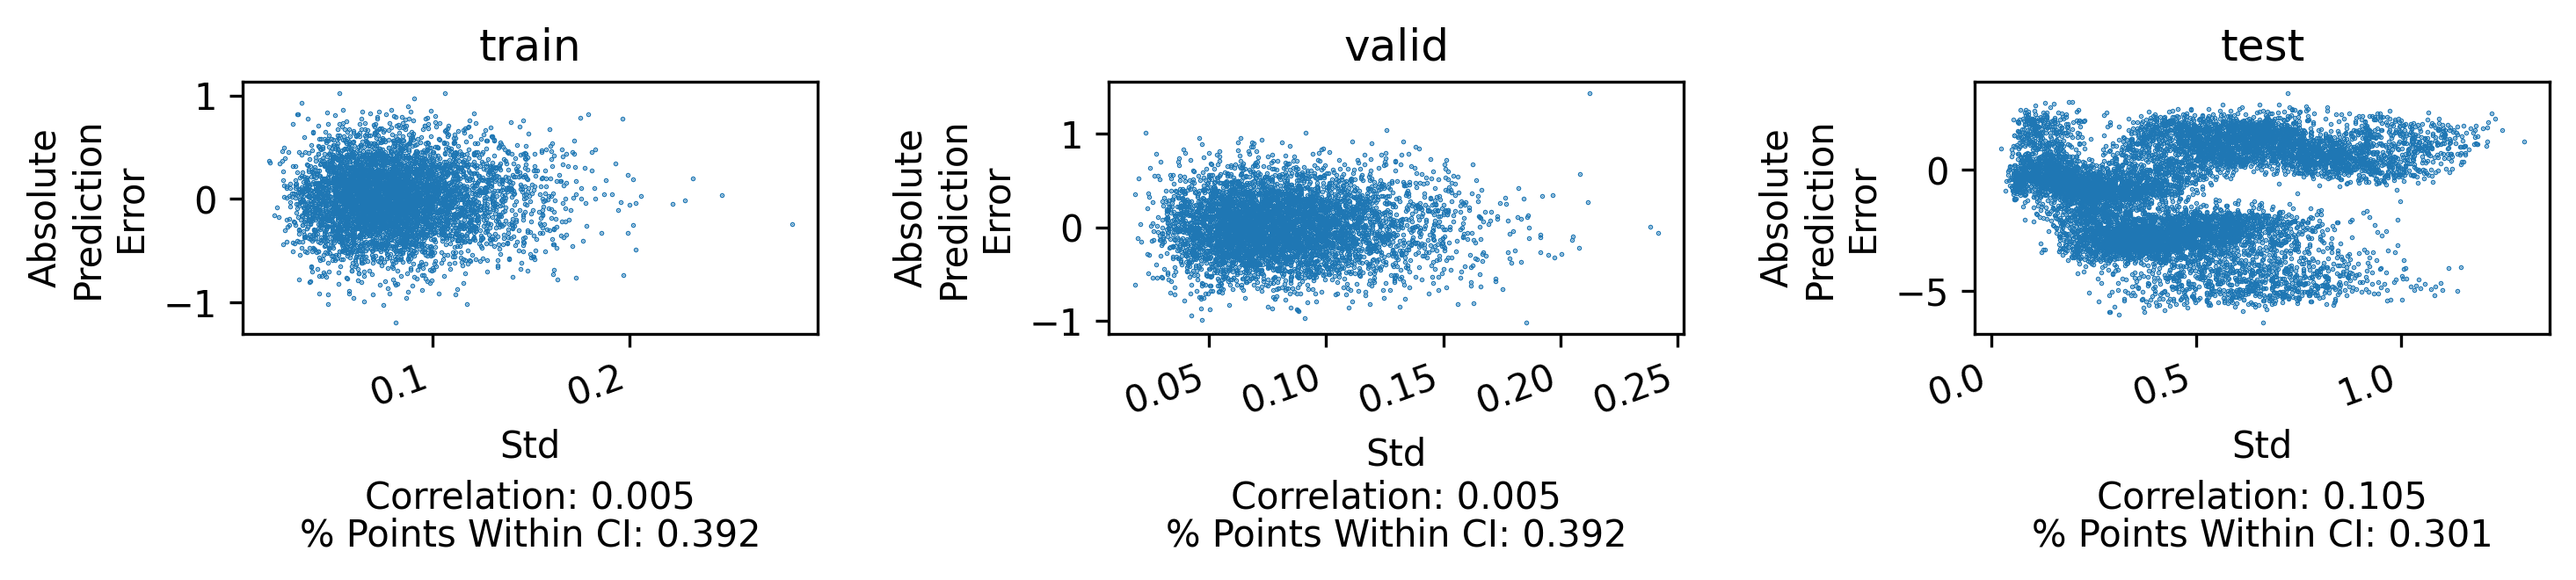

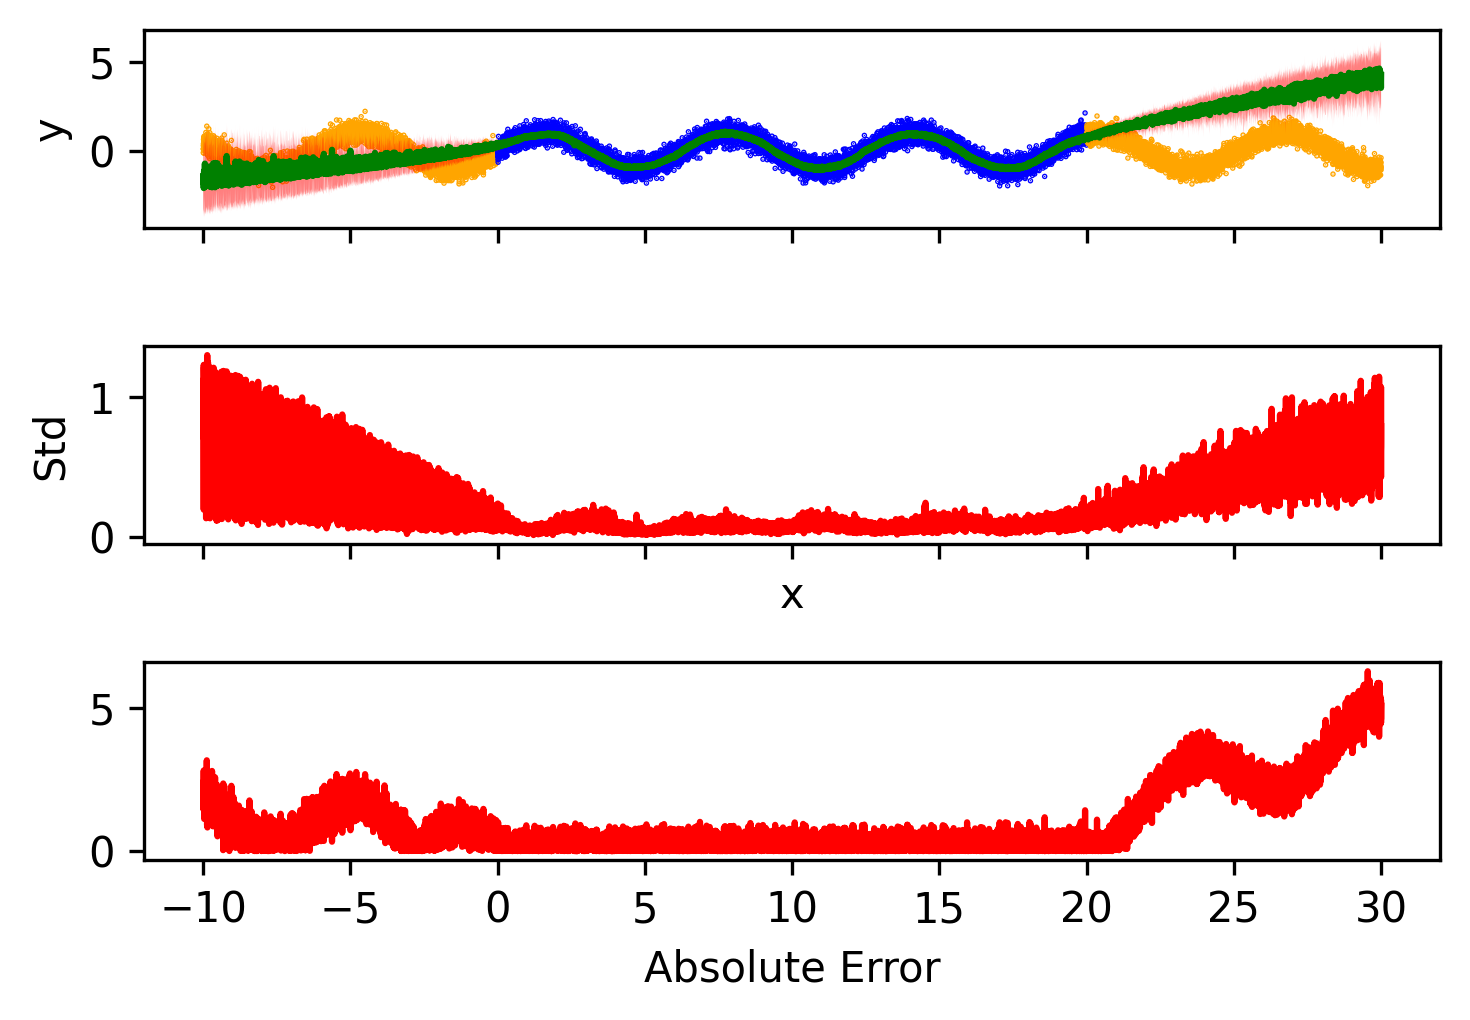

std06:


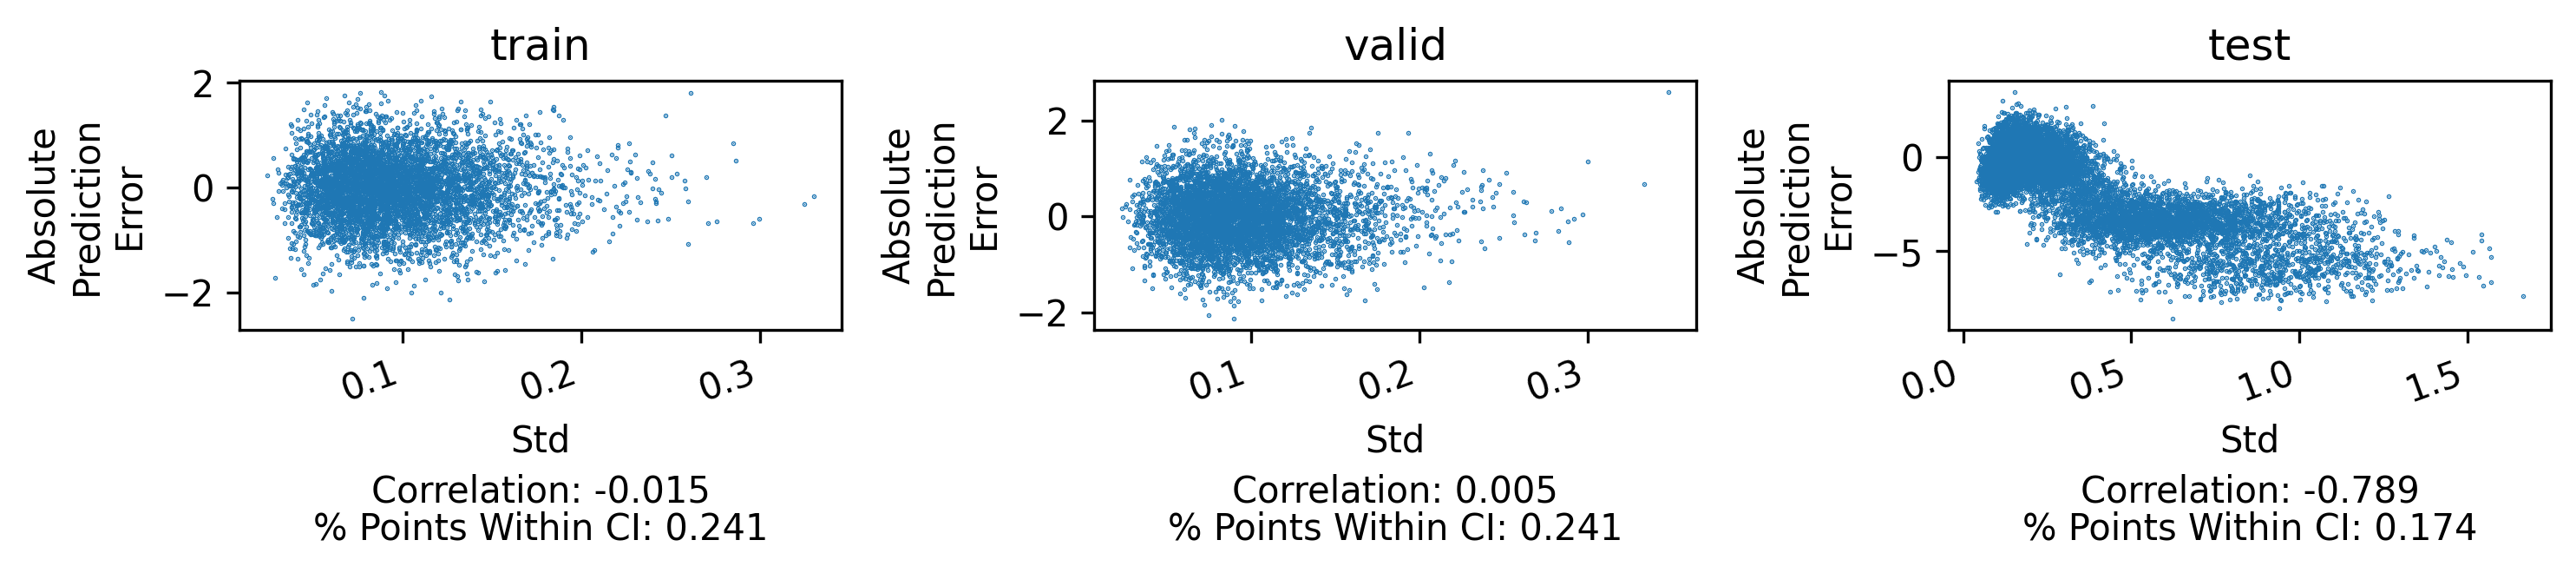

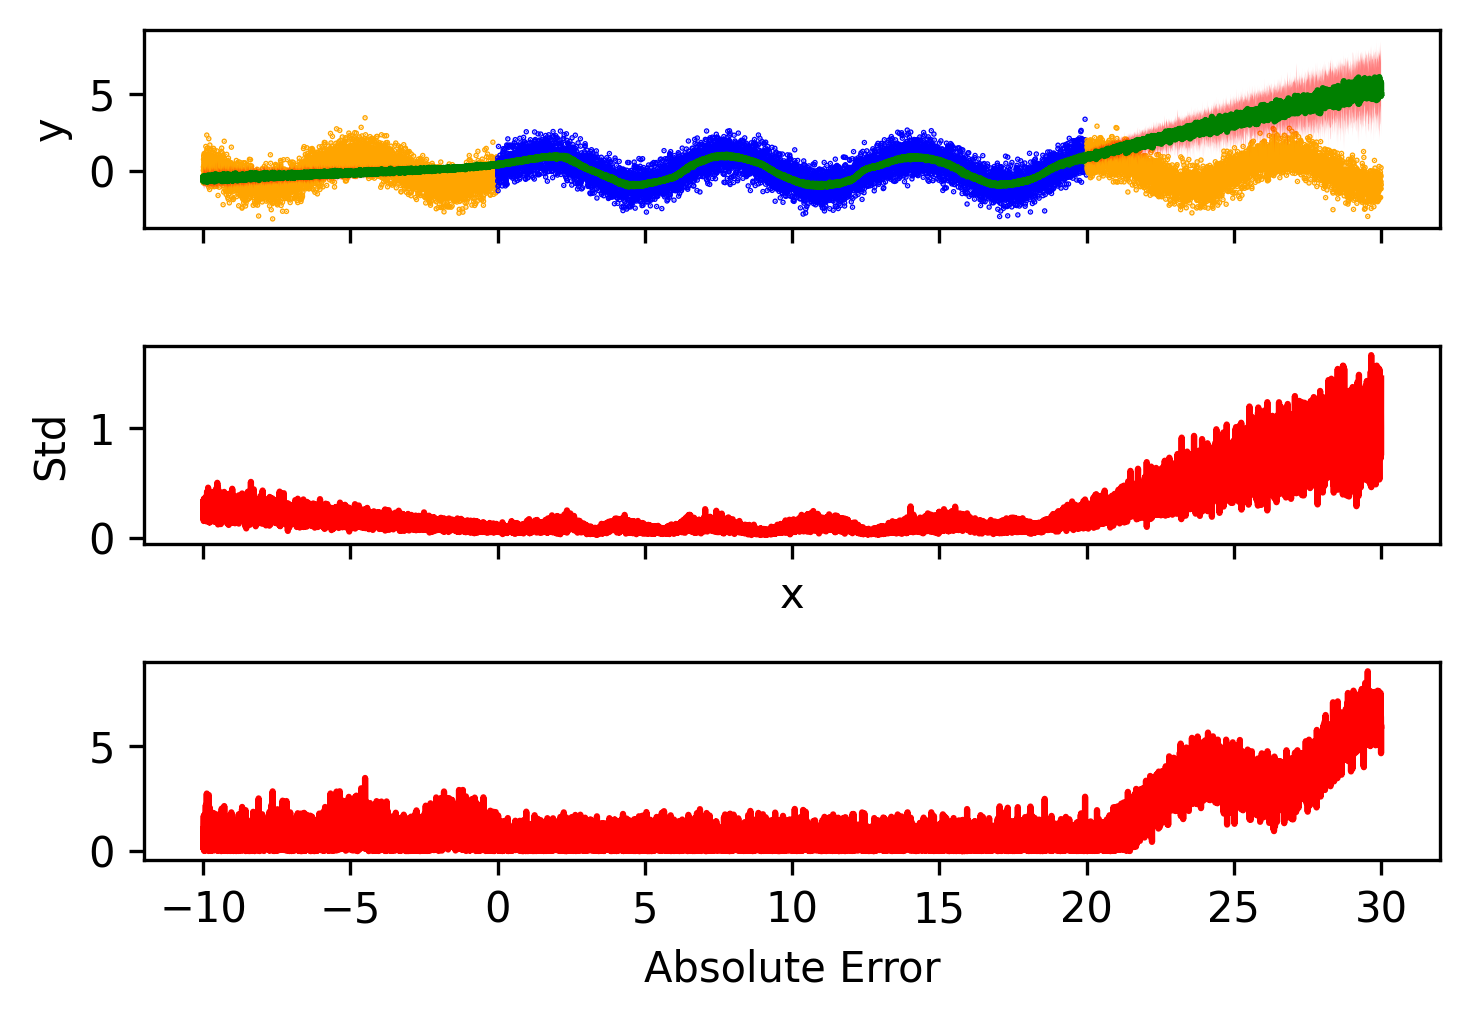

In [35]:
evaluate_all_dropout_models(
    df_dict={"std00":df_std00, "std03":df_std03, "std06":df_std06}, 
    model_dict=dropout_model_dict, 
    save_images=False, with_ci=True
)

## Extra Code

### Gaussian Simulation

In [ ]:
import numpy as np

# Sample size
n = 100000

# Generate data for X and Y from a bivariate Gaussian distribution
mean_XY = [2.0, 5.0]  # Mean of the distribution for X and Y
covariance_matrix_XY = [[1.0, 0.5], [0.5, 2.0]]  # Covariance matrix between X and Y
bivariate_data = np.random.multivariate_normal(mean_XY, covariance_matrix_XY, n)

# do the estimation
esti_mean_XY = np.mean(bivariate_data, axis = 0)
esti_covariance_matrix_XY = np.cov(bivariate_data, rowvar=False)

# Known value of X for which we want to estimate Y
alpha = np.array([9, 8])

# Calculate the conditional mean and standard deviation of Y given X = alpha
conditional_mean_Y = mean_XY[1] + (covariance_matrix_XY[0][1] / covariance_matrix_XY[0][0]) * (alpha - mean_XY[0])

# argmin estimation -- not good
# index = np.argmin(np.abs(bivariate_data[:,0] - alpha))
# esti_Y = bivariate_data[index,1]

# calculate from estimated mean and covariance
esti_conditional_mean_Y = esti_mean_XY[1] + (esti_covariance_matrix_XY[0][1] / esti_covariance_matrix_XY[0][0]) * (alpha - esti_mean_XY[0])
conditional_std_Y = np.sqrt(covariance_matrix_XY[1][1] - (covariance_matrix_XY[0][1]**2 / covariance_matrix_XY[0][0]))
esti_conditional_std_Y = np.sqrt(esti_covariance_matrix_XY[1][1] - (esti_covariance_matrix_XY[0][1]**2 / esti_covariance_matrix_XY[0][0]))

# Display the estimated Y value for X = alpha
print(f"mean_XY:",mean_XY)
print(f"covariance_matrix_XY:",covariance_matrix_XY)
print(f"mean_XY:",esti_mean_XY)
print(f"covariance_matrix_XY:", esti_covariance_matrix_XY)
print(f"Estimated Y for X = {alpha} (GT): {conditional_mean_Y}")
print(f"Estimated Y for X = {alpha} (estimation): {esti_conditional_mean_Y}")
# print(f"Estimated Y for X = {alpha} (argmin): {esti_Y}")
print(f"Estimated Std for X = {alpha} (GT): {conditional_std_Y}")
print(f"Estimated Std for X = {alpha} (estimation): {esti_conditional_std_Y}")

In [ ]:
import numpy as np
testing = np.array([[1.0, 0.5, 0.4], [0.5, 1.0, 0.3], [0.4, 0.3, 1.0]])
print(testing)
print(testing[0, 1:])
print(testing[1:, 1:])
print(testing[1:, 0])

In [ ]:
np.linalg.inv([[3]])

In [ ]:
np.dot(np.array([1,2]),np.array([[3,4], [3, 4]]))

From [wikipedia](https://en.wikipedia.org/wiki/Multivariate_normal_distribution):

In [29]:
# Multivariate
import numpy as np

# Sample size
n = 100000

# Generate data for X and Y from a trivariate Gaussian distribution
# (Y, X1, X2)
mean_YX = np.array([2.0, 3.0, 5.0])  # Mean of the distribution for X and Y
covariance_matrix_YX = np.array([[1.0, 0.5, 0.4], [0.5, 1.0, 0.3], [0.4, 0.3, 1.0]])  # Covariance matrix between Y and X
trivariate_data = np.random.multivariate_normal(mean_YX, covariance_matrix_YX, n)
# trivariate_data[:, 0] += np.random.gamma(2., 2. , n)
print("YX shape:", trivariate_data.shape)

# do the estimation
esti_mean_YX = np.mean(trivariate_data, axis = 0)
esti_covariance_matrix_YX = np.cov(trivariate_data.T, ddof=1)

# Calculate total log probability
from scipy.stats import multivariate_normal
probability = multivariate_normal.pdf(trivariate_data, mean=esti_mean_YX, cov=esti_covariance_matrix_YX)
log_probability = np.log(probability)
total_log_probability = np.mean(log_probability)
print("Mean Log Probability:", total_log_probability)

# # Known value of X1, X2 for which we want to estimate Y
alpha = [9]

# Calculate the conditional mean and var of Y given X = alpha
conditional_mean_Y = (
    mean_YX[0] + 
    np.linalg.multi_dot(
        (covariance_matrix_YX[0, 1:],
        np.linalg.inv(covariance_matrix_YX[1:, 1:]),
        (alpha - mean_YX[1:]))
    )
)
conditional_var_Y = (
    covariance_matrix_YX[0, 0] - 
    np.linalg.multi_dot(
        (covariance_matrix_YX[0, 1:],
        np.linalg.inv(covariance_matrix_YX[1:, 1:]), 
        covariance_matrix_YX[1:, 0])
    )
)
# calculate from estimated mean and covariance
esti_conditional_mean_Y = (
    esti_mean_YX[0] + 
    np.linalg.multi_dot(
        (esti_covariance_matrix_YX[0, 1:],
        np.linalg.inv(esti_covariance_matrix_YX[1:, 1:]),
        (alpha - esti_mean_YX[1:]))
    )
)
esti_conditional_var_Y = (
    esti_covariance_matrix_YX[0, 0] - 
    np.linalg.multi_dot(
        (esti_covariance_matrix_YX[0, 1:],
        np.linalg.inv(esti_covariance_matrix_YX[1:, 1:]), 
        esti_covariance_matrix_YX[1:, 0])
    )
)

# argmin estimation -- not good
index = np.argmin(np.sum(np.abs(trivariate_data[:, 1:] - alpha), axis=1))
esti_Y = trivariate_data[index, 0]

# Display the estimated Y value for X = alpha
print(f"mean_YX:",mean_YX)
print(f"covariance_matrix_YX:",covariance_matrix_YX)
print(f"mean_XY:",esti_mean_YX)
print(f"covariance_matrix_XY:", esti_covariance_matrix_YX)
print(f"conditional_mean_Y: {conditional_mean_Y}")
print(f"esti_conditional_mean_Y: {esti_conditional_mean_Y}")
print(f"Estimated Y for X = {alpha} (GT): {conditional_mean_Y}")
print(f"Estimated Y for X = {alpha} (estimation): {esti_conditional_mean_Y}")
print(f"Estimated Std for X = {alpha} (GT): {np.sqrt(conditional_var_Y)}")
print(f"Estimated Std for X = {alpha} (estimation): {np.sqrt(esti_conditional_var_Y)}")
print(f"Estimated Y for X = {alpha} (argmin): {esti_Y}")

YX shape: (100000, 3)
Mean Log Probability: -4.01916995417274
mean_YX: [2. 3. 5.]
covariance_matrix_YX: [[1.  0.5 0.4]
 [0.5 1.  0.3]
 [0.4 0.3 1. ]]
mean_XY: [2.0053327  3.00184964 5.00372638]
covariance_matrix_XY: [[1.00000571 0.49926948 0.40143237]
 [0.49926948 1.00175936 0.29798434]
 [0.40143237 0.29798434 1.00001111]]
conditional_mean_Y: 5.604395604395605
esti_conditional_mean_Y: 5.608645022635365
Estimated Y for X = [9] (GT): 5.604395604395605
Estimated Y for X = [9] (estimation): 5.608645022635365
Estimated Std for X = [9] (GT): 0.825420305855557
Estimated Std for X = [9] (estimation): 0.8252179797322355
Estimated Y for X = [9] (argmin): 5.157239306388972


In [24]:
# Multivariate
import numpy as np
from sklearn.mixture import GaussianMixture


# Sample size
n = 100000

# Generate data for X and Y from a trivariate Gaussian distribution
# (Y, X1, X2)
mean_YX = np.array([5.0, 2.0])  # Mean of the distribution for X and Y
covariance_matrix_YX = np.array([[2.0, 0.5], [0.5, 1.0]])  # Covariance matrix between Y and X
trivariate_data = np.random.multivariate_normal(mean_YX, covariance_matrix_YX, n)
print("X shape:", trivariate_data.shape)

# do the estimation
esti_mean_YX = np.mean(trivariate_data, axis = 0)
esti_covariance_matrix_YX = np.cov(trivariate_data.T, ddof=1)

# Calculcate total log probability
from scipy.stats import multivariate_normal
probability = multivariate_normal.pdf(trivariate_data, mean=esti_mean_YX, cov=esti_covariance_matrix_YX)
log_probability = np.log(probability)
total_log_probability = np.sum(log_probability)
print("Total Log Probability:", total_log_probability)

# # Known value of X1, X2 for which we want to estimate Y
alpha = [[9], [8]]

# Calculate the conditional mean and var of Y given X = alpha
conditional_mean_Y = (
    mean_YX[0] + 
    np.linalg.multi_dot(
        (covariance_matrix_YX[0, 1:],
        np.linalg.inv(covariance_matrix_YX[1:, 1:]),
        (alpha - mean_YX[1:]).T)
    )
)
conditional_var_Y = (
    covariance_matrix_YX[0, 0] - 
    np.linalg.multi_dot(
        (covariance_matrix_YX[0, 1:],
        np.linalg.inv(covariance_matrix_YX[1:, 1:]), 
        covariance_matrix_YX[1:, 0])
    )
)
# calculate from estimated mean and covariance
esti_conditional_mean_Y = (
    esti_mean_YX[0] + 
    np.linalg.multi_dot(
        (esti_covariance_matrix_YX[0, 1:],
        np.linalg.inv(esti_covariance_matrix_YX[1:, 1:]),
        (alpha - esti_mean_YX[1:]).T)
    )
)
esti_conditional_var_Y = (
    esti_covariance_matrix_YX[0, 0] - 
    np.linalg.multi_dot(
        (esti_covariance_matrix_YX[0, 1:],
        np.linalg.inv(esti_covariance_matrix_YX[1:, 1:]), 
        esti_covariance_matrix_YX[1:, 0])
    )
)

# argmin estimation -- not good
# index = np.argmin(np.sum(np.abs(trivariate_data[:, 1:] - alpha), axis=1))
# esti_Y = trivariate_data[index, 0]

# Display the estimated Y value for X = alpha
print(f"mean_YX:",mean_YX)
print(f"covariance_matrix_YX:",covariance_matrix_YX)
print(f"mean_XY:",esti_mean_YX)
print(f"covariance_matrix_XY:", esti_covariance_matrix_YX)
print(f"conditional_mean_Y: {conditional_mean_Y}")
print(f"esti_conditional_mean_Y: {esti_conditional_mean_Y}")
print(f"Estimated Y for X = {alpha} (GT): {conditional_mean_Y}")
print(f"Estimated Y for X = {alpha} (estimation): {esti_conditional_mean_Y}")
print(f"Estimated Std for X = {alpha} (GT): {np.sqrt(conditional_var_Y)}")
print(f"Estimated Std for X = {alpha} (estimation): {np.sqrt(esti_conditional_var_Y)}")
# print(f"Estimated Y for X = {alpha} (argmin): {esti_Y}")

X shape: (100000, 2)
Total Log Probability: -311918.25829773565
mean_YX: [5. 2.]
covariance_matrix_YX: [[2.  0.5]
 [0.5 1. ]]
mean_XY: [4.99887938 1.99872432]
covariance_matrix_XY: [[2.00765169 0.49734917]
 [0.49734917 0.99750412]]
conditional_mean_Y: [8.5 8. ]
esti_conditional_mean_Y: [8.48967061 7.99107701]
Estimated Y for X = [[9], [8]] (GT): [8.5 8. ]
Estimated Y for X = [[9], [8]] (estimation): [8.48967061 7.99107701]
Estimated Std for X = [[9], [8]] (GT): 1.3228756555322954
Estimated Std for X = [[9], [8]] (estimation): 1.3265280169247162


### GPR Tutorial

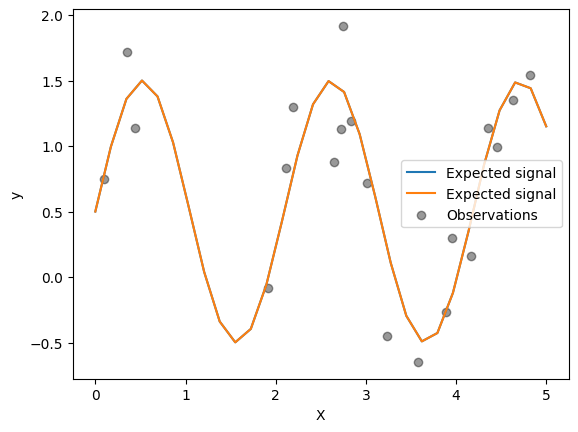

In [78]:
# Tutorial of GPR from: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html
import numpy as np

def target_generator(X, add_noise=False):
    target = 0.5 + np.sin(3 * X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 0.3, size=target.shape)
    return target.squeeze()

X = np.linspace(0, 5, num=30).reshape(-1, 1)
y = target_generator(X, add_noise=False)

import matplotlib.pyplot as plt

plt.plot(X, y, label="Expected signal")
plt.legend()
plt.xlabel("X")
_ = plt.ylabel("y")


rng = np.random.RandomState(0)
X_train = rng.uniform(0, 5, size=20).reshape(-1, 1)
y_train = target_generator(X_train, add_noise=True)

plt.plot(X, y, label="Expected signal")
plt.scatter(
    x=X_train[:, 0],
    y=y_train,
    color="black",
    alpha=0.4,
    label="Observations",
)
plt.legend()
plt.xlabel("X")
_ = plt.ylabel("y")

C:\Users\WLR\anaconda3\envs\ci\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


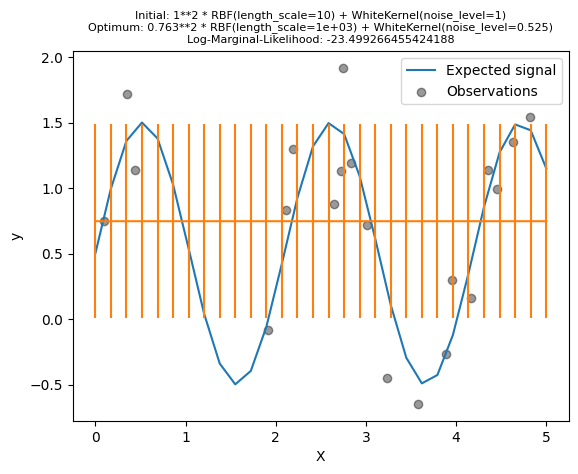

In [79]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-5, 1e1)
)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
gpr.fit(X_train, y_train)
y_mean, y_std = gpr.predict(X, return_std=True)

plt.plot(X, y, label="Expected signal")
plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observations")
plt.errorbar(X, y_mean, y_std)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
_ = plt.title(
    (
        f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
        f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}"
    ),
    fontsize=8,
)

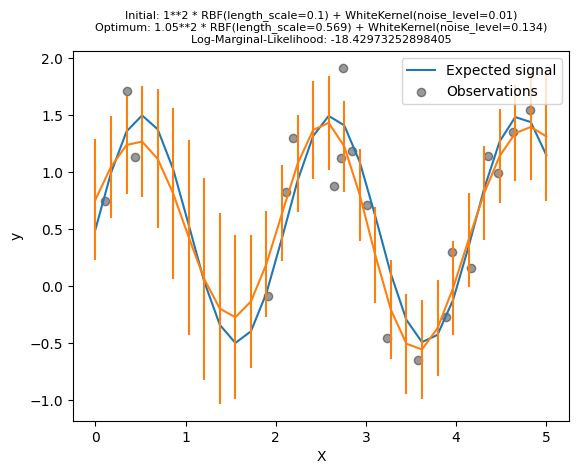

In [81]:
# Previous kernel
# kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
#     noise_level=1, noise_level_bounds=(1e-5, 1e1)
# )
# initialize the RBF with a larger length_scale -> targets: the model does not provide faithful predictions
# and the WhiteKernel with a smaller noise level lower bound. -> targets: smaller noise than the bounds found
kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-10, 1e1)
)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
gpr.fit(X_train, y_train)
y_mean, y_std = gpr.predict(X, return_std=True)

plt.plot(X, y, label="Expected signal")
plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observations")
plt.errorbar(X, y_mean, y_std)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
_ = plt.title(
    (
        f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
        f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}"
    ),
    fontsize=8,
)

# Old Code

In [ ]:
def model_prediction_ae(ae_regressor, all_df, predictors, pred_cols, pred_min, seed=seed):
    
    
    
    # ae_regressor, all_df, split_col, predictors, pred_cols, ood_lab, generate_ci, save_images, with_ci
    # Get predictions
    x = all_df[predictors].values.astype('float32')
    y = all_df[pred_cols].values.astype('float32')
    y_pred, x_reconstruction = ae_regressor.predict(x)
    
    # Calculate errors
    pe = y-y_pred
    re = x-x_reconstruction
    
    # Column names
    pred_col = pred_cols[0]
    y_pred_col = "y_pred"
    pe_col, abs_pe_col = "pe", "abs_pe"
    re_col, abs_re_col = "re", "abs_re" # reconstruction error
    ood_pred_col = "ood_pred" # column with labels for samples labelled as out of distribution by the method
    ci_col = "ci"
    x_col = "x"
    
    # Calculate absolute errors
    abs_pe = np.abs(pe)
    abs_re = np.abs(re)
    
    # Add calculated values
    all_df[y_pred_col] = y_pred
    all_df[pe_col], all_df[abs_pe_col] = pe, abs_pe
    all_df[re_col], all_df[abs_re_col] = re, abs_re
    
    # Separate df
    train_df, valid_df, test_df = (
        all_df[all_df[split_col]=="train"], 
        all_df[all_df[split_col]=="valid"], 
        all_df[all_df[split_col]=="test"])
    
    # Label ood samples
    all_df[ood_pred_col] = identify_ood(
        valid_re=valid_df[re_col], test_re=all_df[re_col])
    
    # Get CI
    all_df[ci_col] = generate_ci( 
        valid_pe=valid_df[pe_col].values, valid_re=np.expand_dims(valid_df[re_col], axis=1), 
        test_re=np.expand_dims(all_df[re_col], axis=1)
    )
    
    # Show relationship between delta and mae
    plot_error_and_uncertainty(
        df=all_df, pe_lab=pe_col, ue_lab=re_col, ci_lab=ci_col, split_lab=split_col, xlabel="Reconstruction Error",
        save_images=save_images
    )
#     from pingouin import multivariate_normality
    train_valid_df = all_df[all_df[split_col]!="test"]
#     print("Valid:",
#         multivariate_normality(valid_df[[re_col, pe_col]], alpha=.05))
#     print("Train + Valid:",
#         multivariate_normality(train_valid_df[[re_col, pe_col]], alpha=.05))
    all_df = all_df.sort_values(by=x_col)
    
    # Show predictions as a line with CI
    plot_predictions(
        all_df, x_lab=predictors, y_lab=pred_cols, pe_lab=pe_col,
        ue_lab=re_col, pred_lab=y_pred_col, ci_lab=ci_col, ylabel="RUE", ood_lab=ood_pred_col, 
        save_images=save_images, with_ci=with_ci, 
    )
    
    return all_df

def identify_ood(valid_re, test_re):
    valid_re, test_re = np.abs(valid_re), np.abs(test_re)
    return test_re > max(valid_re)

def nearest_neighbours_ci(valid_re, valid_pe, test_re):
    # Set K = sqrt of size of validation set
    k = round(np.sqrt(len(valid_re)))
    # Use kdtree to query nearest k neighbours based on RE
#     from sklearn.neighbors import KDTree
    from scipy.spatial import KDTree
    kdtree = KDTree(valid_re)
    # Get k nearest neighbours of each test sample based on RE
    dist, ind = kdtree.query(test_re, k=k, workers=-1)
    # Get k nearest neigbour's deltas
#     print(ind)
#     print(valid_pe.shape)
#     print(ind.shape)
    neighbour_deltas = np.abs(valid_pe[ind])
    # CI = 0.95 Percentile of neigbouring deltas
    ci = np.percentile(neighbour_deltas, 95, axis=1)
    return ci

def get_standard_gaussian_mean_log_probability(data, mean, cov, seed):
    np.random.seed(seed)
    n = len(data)
    data = np.random.multivariate_normal(mean, cov, n)
#     plt.scatter(data[:,1], data[:,0])
    mean_log_probability = calculate_mean_log_probability(data, mean, cov)
    return mean_log_probability

def calculate_mean_log_probability(data, mean, cov):
    from scipy.stats import multivariate_normal
    log_probability = multivariate_normal.logpdf(data, mean=mean, cov=cov)
    mean_log_probability = np.mean(log_probability)
    return mean_log_probability

def conditional_gaussian_distribution_ci(valid_re, valid_pe, test_re, seed=seed):
    data = np.hstack((np.expand_dims(valid_pe, axis=1), valid_re))
    
    # Estimate joint mean and covariance
    esti_mean_YX = np.mean(data, axis = 0)
    esti_covariance_matrix_YX = np.cov(data.T, ddof=1)
    
    # Calculate mean log probability
    mean_log_probability = calculate_mean_log_probability(data, esti_mean_YX, esti_covariance_matrix_YX)
    print("Mean Log Probability:", mean_log_probability)
    std_mean_log_probability = get_standard_gaussian_mean_log_probability(data, esti_mean_YX, esti_covariance_matrix_YX, seed=seed)
    print("Baseline Mean Log Probability:", std_mean_log_probability)
    
    # Known value of X1, X2 for which we want to estimate Y
    alpha = test_re
    
    # calculate from estimated mean and covariance
    esti_conditional_mean_Y = (
        esti_mean_YX[0] + 
        np.linalg.multi_dot(
            (esti_covariance_matrix_YX[0, 1:],
            np.linalg.inv(esti_covariance_matrix_YX[1:, 1:]),
            (alpha - esti_mean_YX[1:]).T)
        )
    )
    
    esti_conditional_var_Y = (
        esti_covariance_matrix_YX[0, 0] - 
        np.linalg.multi_dot(
            (esti_covariance_matrix_YX[0, 1:],
            np.linalg.inv(esti_covariance_matrix_YX[1:, 1:]), 
            esti_covariance_matrix_YX[1:, 0])
        )
    )
    esti_conditional_std_Y = np.sqrt(esti_conditional_var_Y)

    from scipy.stats import norm
    ci = norm.ppf(0.975, loc=esti_conditional_mean_Y, scale=esti_conditional_std_Y)
    return ci.flatten()

# def plot_error_and_uncertainty(df, pe_lab, ue_lab, split_lab, xlabel, ci_lab, save_images):
#     from scipy.stats import pearsonr
#     fig, axes = plt.subplots(1,3, figsize=(10, 4), dpi=300)
    
#     df = df.copy()

#     for i, split in enumerate(["train", "valid", "test"]):
#         split_df = df[df["split"]==split]
#         corr, p_value = pearsonr(split_df[ue_lab], split_df[pe_lab])
#         prop = (np.abs(split_df[pe_lab])<=split_df[ci_lab]).sum()/len(split_df)
#         axes[i].set_title(split)
#         axes[i].scatter(split_df[ue_lab], split_df[pe_lab], s=0.1)
#         axes[i].set_ylabel("Absolute\nPrediction\nError")
#         axes[i].set_xlabel(xlabel)
#         axes[i].text(0.5, -0.65, f"Correlation: {round(corr, 3)}", ha="center", va="center", transform=axes[i].transAxes)
#         axes[i].text(0.5, -0.80, f"% Points Within CI: {round(prop, 3)}", ha="center", va="center", transform=axes[i].transAxes)
#         plt.setp(axes[i].get_xticklabels(), rotation=20, horizontalalignment='right')
#     plt.tight_layout()
#     if save_images:
#         save_image_to_file("plot_errors")
#     plt.show()